In [333]:
import pandas as pd 
import numpy as np 
import quandl as qdl
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt 

import plotly as plotly
import plotly.graph_objs as go
import plotly.express as px

import yfinance as yf


# Importing the pandas library for data manipulation and analysis
import pandas as pd

# Importing the matplotlib library for creating visualizations
import matplotlib.pyplot as plt

# Importing the backtrader library for backtesting trading strategies
import backtrader as bt

# Importing the numpy library for numerical computing
import numpy as np

# Importing matrix, solvers, and blas from cvxopt library for convex optimization
from cvxopt import matrix, solvers, blas

# Importing the tabulate library for creating tables
from tabulate import tabulate

# Importing the datetime module to work with dates and times
import datetime

# Importing the matplotlib library again (this line is redundant)
import matplotlib.pyplot as plt

# Importing the cvxopt library for convex optimization 
import cvxopt as opt

# Importing quantStats for quantitative financial analysis
import quantstats as qs

import math

In [334]:
plotly.offline.init_notebook_mode(connected=True) 

# Setting the maximum number of columns to display in pandas to None, which means all columns will be displayed
pd.set_option('display.max_columns', None)

# Setting the maximum number of rows to display in pandas to None, which means all rows will be displayed
pd.set_option('display.max_rows', None)

# Using the magic command %matplotlib inline to display matplotlib plots inline in a Jupyter notebook
%matplotlib inline

# Setting the random seed for numpy to 42 for reproducibility
np.random.seed(42)

# Setting the 'show_progress' option for solvers in cvxopt library to False, which means no progress will be shown while solving
solvers.options['show_progress'] = False


In [335]:
data=pd.read_csv('final_inds.csv')
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)

In [336]:
px.line(data, x=data.index, y="USRECM", title='Economic Indicators')

In [337]:
def log_diff(v):
    return np.log(v/v.shift(1))

In [338]:
print(data.columns)

Index(['USRECM', 'FEDFUNDS', 'PAYEMS', 'UNRATE', 'INDPRO', 'T10YFF'], dtype='object')


In [339]:
SPY_stock_data = pd.read_csv('SPX_final.csv')
SPY_stock_data['DATE'] = pd.to_datetime(SPY_stock_data['DATE'])
SPY_stock_data.set_index('DATE', inplace=True)

VIX_data=pd.read_csv('VIX2.csv')
VIX_data.rename(columns={'Date':'DATE'}, inplace=True)
VIX_data['DATE'] = pd.to_datetime(VIX_data['DATE'])
VIX_data.set_index('DATE', inplace=True)

In [340]:
print(SPY_stock_data.columns)
print(VIX_data.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [341]:
# select the first value of each month
SPY_stock_data = SPY_stock_data.resample('M').first()
data = data.resample('M').first()
data.rename(columns={'USRECM':'recession', 'FEDFUNDS':'fedfunds','UNRATE':'unemploy','INDPRO':'indpro','T10YFF':'ty10','PAYEMS':'nonfarm'}, inplace=True)

In [342]:
print("There are a total of {} months of recession in this data".format(data["recession"].sum()))

There are a total of 93.0 months of recession in this data


In [343]:
def log_diff(v): 
    log_diff = np.log(v/v.shift(1))
    return log_diff 

In [344]:
# preprocessing 
data["slope_yc"] = (data["ty10"] - data["fedfunds"])
data["fedfunds"] = data["fedfunds"].diff()
data["indpro"] = log_diff(data["indpro"]) 
data["nonfarm"] =  log_diff(data["nonfarm"])
data["SP500"] =  log_diff(SPY_stock_data["Close"])
data["ty10"]  = (data["ty10"]).diff()
data["unemploy"] = log_diff(data["unemploy"])
data["recession"] = data["recession"].shift(1)

In [345]:
data.head()

,recession,fedfunds,nonfarm,unemploy,indpro,ty10,slope_yc,SP500
DATE,,,,,,,,
1962-01-31,NaN,NaN,NaN,NaN,NaN,NaN,-0.84,NaN
1962-02-28,0.0,0.22,0.005396,-0.053110,0.016225,0.53,-0.53,-0.024249
1962-03-31,0.0,0.48,0.001575,0.018019,0.005353,-0.36,-1.37,0.013481
1962-04-30,0.0,-0.07,0.005898,0.000000,0.002129,-0.37,-1.67,-0.011894
1962-05-31,0.0,-0.42,0.000467,-0.018019,-0.001066,0.24,-1.01,-0.054356


In [346]:
# drop missing values 
len_before = len(data)
data.dropna(inplace=True)
len_after = len(data)

print("Dropped {} rows".format(len_before - len_after))

Dropped 23 rows


In [347]:
data.head()

,recession,fedfunds,nonfarm,unemploy,indpro,ty10,slope_yc,SP500
DATE,,,,,,,,
1962-02-28,0.0,0.22,0.005396,-0.053110,0.016225,0.53,-0.53,-0.024249
1962-03-31,0.0,0.48,0.001575,0.018019,0.005353,-0.36,-1.37,0.013481
1962-04-30,0.0,-0.07,0.005898,0.000000,0.002129,-0.37,-1.67,-0.011894
1962-05-31,0.0,-0.42,0.000467,-0.018019,-0.001066,0.24,-1.01,-0.054356
1962-06-30,0.0,0.32,0.000288,0.000000,-0.002132,-0.21,-1.54,-0.101141


In [348]:
c1 = data["recession"].value_counts()[0]
c2 = data["recession"].value_counts()[1]
print(data["recession"].value_counts())
print("The minority class only makes up {} % ".format(round(c2/c1 * 100, 2)))

0.0    613
1.0     93
Name: recession, dtype: int64
The minority class only makes up 15.17 % 


In [349]:
# get x and y 
X = data.drop(['recession'], axis=1)
y = data["recession"]

In [350]:
# divide in train test according to paper 
X_train, y_train =  (X.loc["1962-02-28":"2007-01-01"], y.loc["1962-02-28":"2007-01-01"])
X_test, y_test =  (X.loc["2007-01-01":], y.loc["2007-01-01":])

In [351]:
## Sampling techniques

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# oversample using SMOTE 
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

# undersample randomly
rus = RandomUnderSampler(random_state=42)
X_train_rnd, y_train_rnd  = rus.fit_resample(X_train, y_train)

In [352]:
train_test_pairs = {"Normal":(X_train, y_train), 
                    "SMOTE":(X_train_smote, y_train_smote), 
                    "Random Undersampling":(X_train_rnd, y_train_rnd)}

In [353]:
clfs = {"Logistic Regression": LogisticRegression(),
       "Decision Tree": tree.DecisionTreeClassifier(),
       "Random Forest": RandomForestClassifier(max_depth=15, 
                                                      n_estimators=200, 
                                                      class_weight = "balanced_subsample", 
                                                      random_state=42)}

In [354]:
fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

for label, pair in train_test_pairs.items(): 
    clf = RandomForestClassifier(max_depth=15, 
                                 n_estimators=200, 
                                 class_weight = "balanced_subsample", 
                                 random_state=42)
    clf.fit(pair[0], pair[1])
    y_pred= clf.predict(X_test) 
    fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test, clf.predict(X_test))

    name = f"{label} (AUC={auc:.2f})"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

fig.update_layout(
xaxis_title='False Positive Rate',
yaxis_title='True Positive Rate',
yaxis=dict(scaleanchor="x", scaleratio=1),
xaxis=dict(constrain='domain'),
width=900, height=700
)
fig.update_layout(title_text="Comparing sampling strategies")
fig.show()

In [355]:
fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

for name, clf in clfs.items(): 
    clf.fit(X_train_rnd, y_train_rnd)
    y_pred= clf.predict(X_test) 
    fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test, clf.predict(X_test))

    name = f"{name} (AUC={auc:.2f})"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=900, height=700
)
fig.update_layout(title_text="Comparing different models")
fig.show()

In [356]:
print(clf)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       n_estimators=200, random_state=42)


In [357]:
y_pred = clf.predict(X_test)
y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.])

In [358]:
import yfinance as yf

results = pd.DataFrame()

results['SPY']=SPY_stock_data['2007-01-01':]['Close'].resample('M').mean()
results['VIX']=VIX_data['2007-01-01':]['Close'].resample('M').mean()
results['GLD']=yf.download('GLD','2007-01-01')['Close'].resample('M').mean()
print(results.head())

[*********************100%***********************]  1 of 1 completed
                    SPY        VIX        GLD
DATE                                         
2007-01-31  1416.599976  11.042500  62.551000
2007-02-28  1445.939941  11.155263  65.949474
2007-03-31  1403.170044  15.162727  64.817728
2007-04-30  1424.550049  12.933000  67.368000
2007-05-31  1486.300049  13.297727  66.158636


In [359]:
# strategies
pred_shift_back = pd.Series(y_pred).shift(-1).fillna(method='ffill')
spy_long_preds = (pred_shift_back -1) *(-1) 
results["SPY Long"] = results["SPY"].pct_change()
results["SPY Long wo recessions"] = spy_long_preds.values * results["SPY Long"].values 
results["SPY Long add GLD"] = ((results["GLD"].pct_change().values * pred_shift_back) + results["SPY Long"].values).values
results["SPY Long add VIX"] = ((results["VIX"].pct_change().values * pred_shift_back) + results["SPY Long"].values).values

In [360]:
fig = go.Figure()
fig.add_scatter(x= results.index, y=results['SPY Long'].cumsum(), mode='lines', name="SPY long")
fig.add_scatter(x= results.index, y=results["SPY Long wo recessions"].cumsum(), mode='lines', name="SPY wo recession")
fig.add_scatter(x= results.index, y=results["SPY Long add GLD"].cumsum(), mode='lines', name="SPY + GLD")
fig.add_scatter(x= results.index, y=results["SPY Long add VIX"].cumsum(), mode='lines', name="SPY + VIX")
fig.update_layout(title_text="Different Strategies during Recessions")
fig.show()

In [361]:
# Permutation Importance 
# see https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html
from sklearn.inspection import permutation_importance

result = permutation_importance(clf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig = go.Figure()
for i in range(0, len(X_test.columns)):
    fig.add_trace(go.Box(x = result.importances[sorted_idx][i], name=X_test.columns[sorted_idx][i]))
fig.show()

In [362]:
import shap

In [363]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

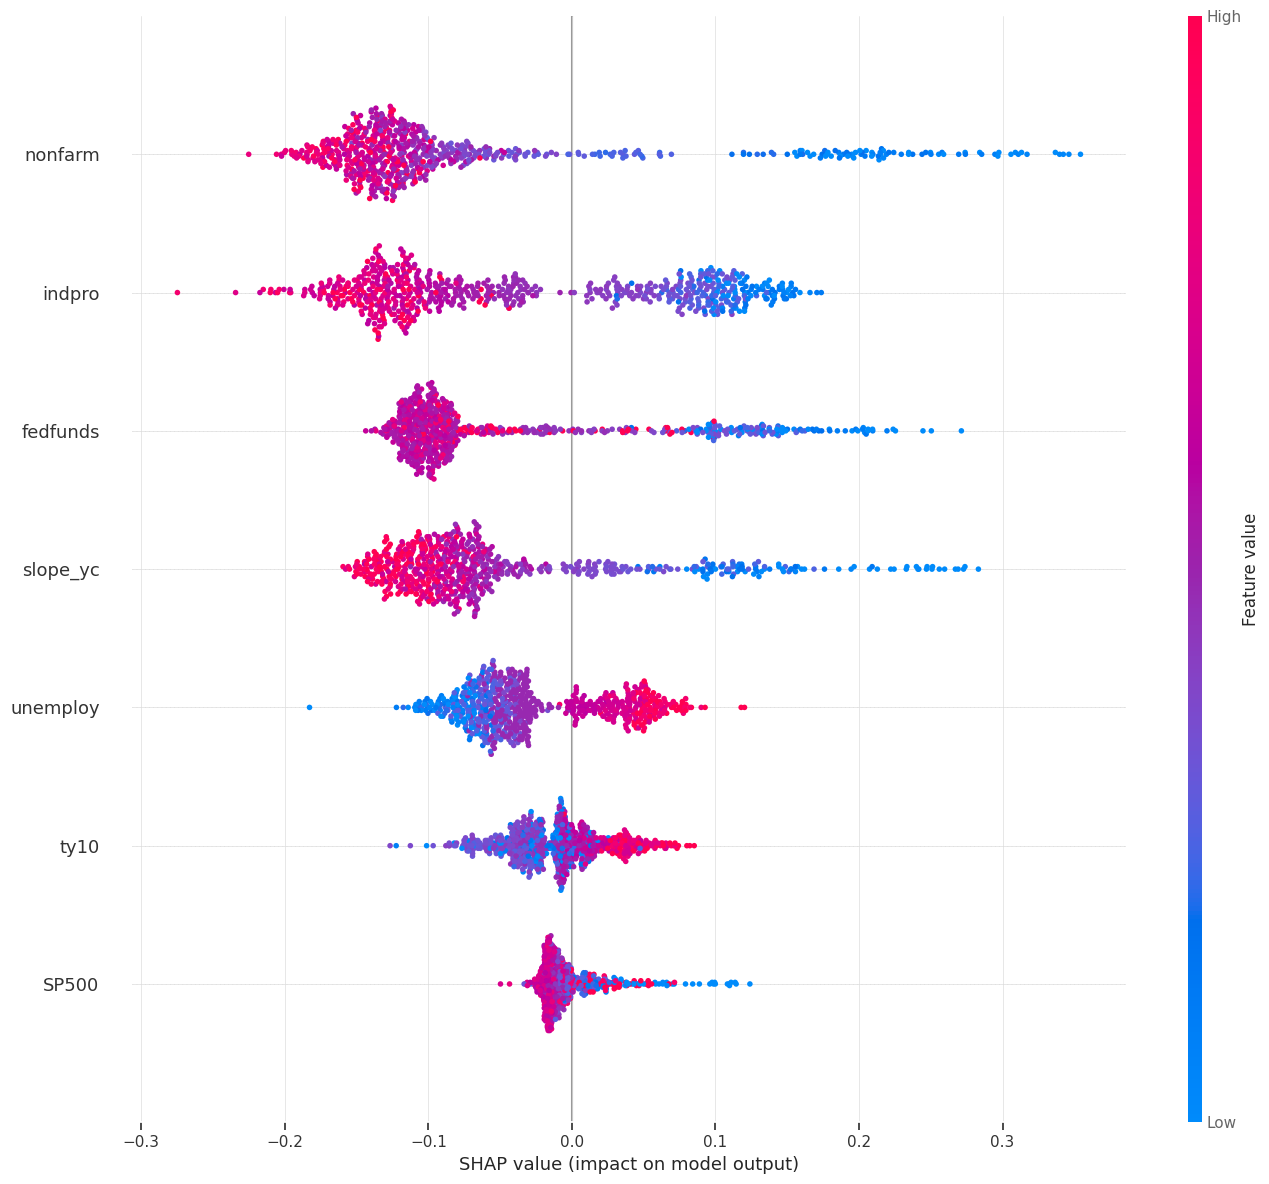

In [364]:
# summarize the effects of all the features
shap.summary_plot(shap_values[1], X, plot_type="dot",plot_size=(14,12))

In [365]:

shap_interaction_values = shap.TreeExplainer(clf).shap_interaction_values(X)

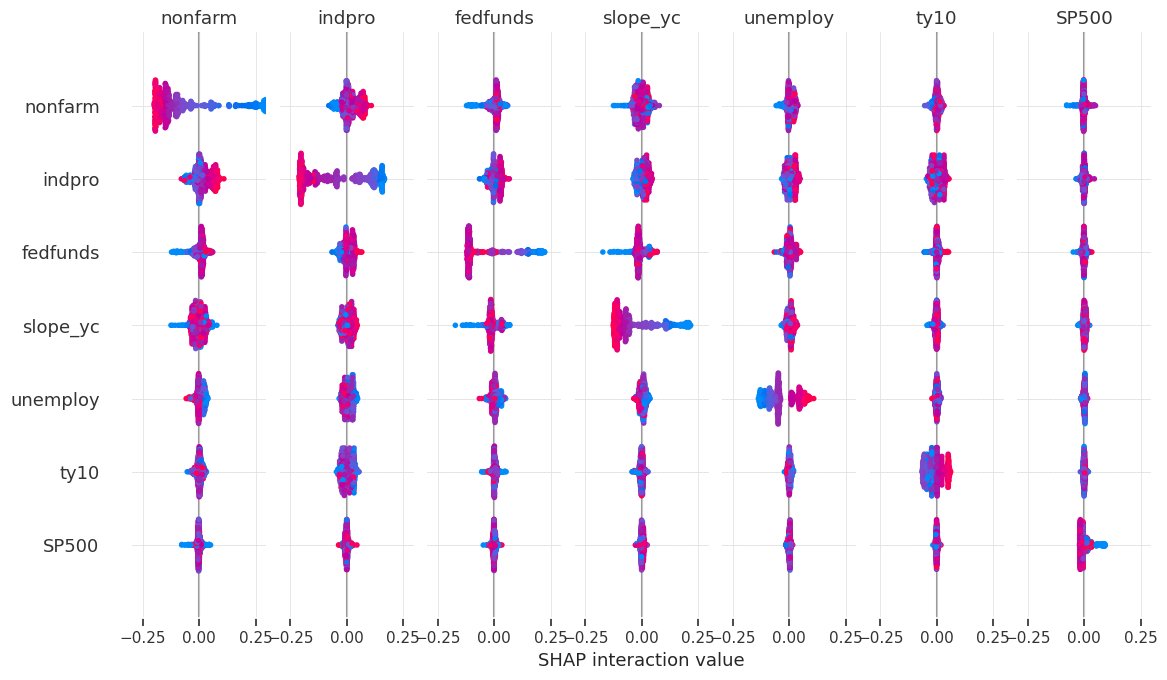

In [366]:
# summaries interaction effect
shap.summary_plot(shap_interaction_values[1], X, plot_size=(14,16))

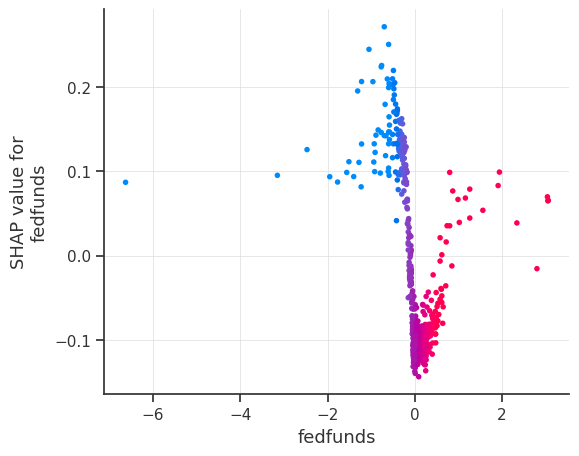

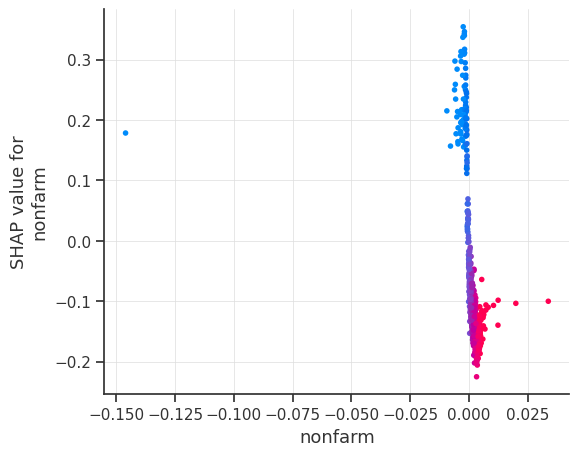

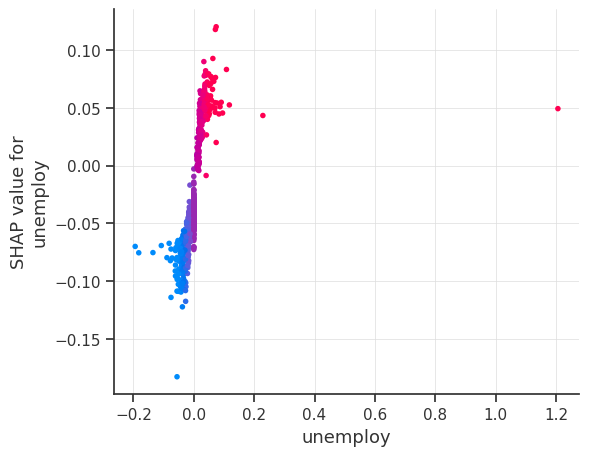

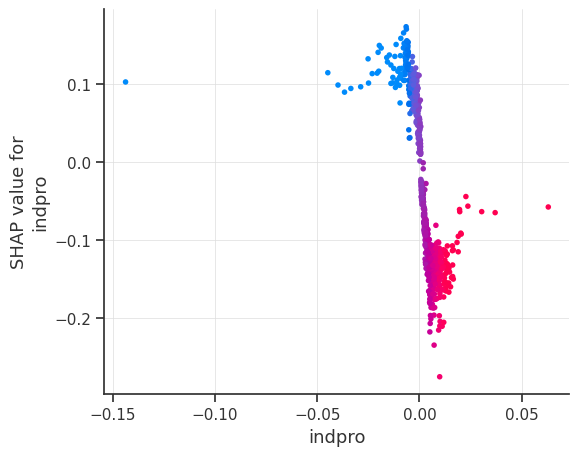

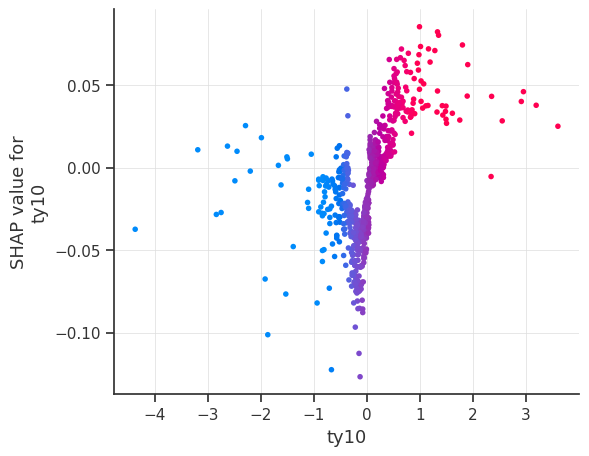

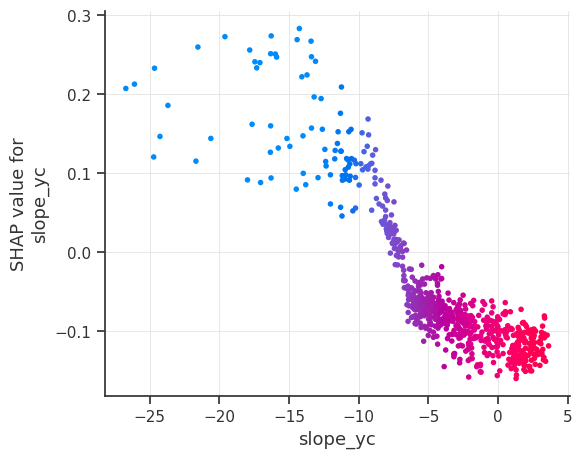

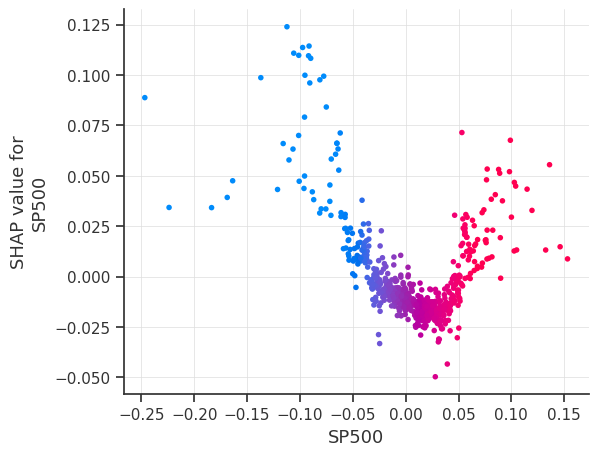

In [367]:
for feature in X.columns: 
    shap.dependence_plot(feature, shap_values[1], X, interaction_index=feature)

In [368]:
SPY_stock_data = pd.read_csv('SPY.csv')
SPY_stock_data.rename(columns={'Date':'DATE'}, inplace=True)
SPY_stock_data['DATE'] = pd.to_datetime(SPY_stock_data['DATE'])
SPY_stock_data.set_index('DATE', inplace=True)

VIX_data=pd.read_csv('VIX2.csv')
VIX_data.rename(columns={'Date':'DATE'}, inplace=True)
VIX_data['DATE'] = pd.to_datetime(VIX_data['DATE'])
VIX_data.set_index('DATE', inplace=True)


QQQ_data = pd.read_csv('QQQ.csv')
QQQ_data.rename(columns={'Date':'DATE'}, inplace=True)
QQQ_data['DATE'] = pd.to_datetime(QQQ_data['DATE'])
QQQ_data.set_index('DATE', inplace=True)

In [376]:
# Defining a class named 'MeanVarOpt' that inherits from the 'bt.Strategy' class
class MeanVarOpt(bt.Strategy):
    # Defining the strategy parameters as a tuple of tuples
    params = (
        ('lookback', 550),  # Lookback period for calculating returns
        ('alpha',0.971),  # maximum portfolio value to be invested on a single day
        ('beta',5), # number of days you want to carry forward buying alpha % of stocks
        ('gamma',0.95), # buys stocks in two parts
        ('printLog',True),
    )
    
    # Defining the __init__ method to initialize the instance variables
    def __init__(self):
        
        # Initializing an instance variable to store the selected stocks
        self.selected_stocks = []
        
        # Adding all tickers to the list of selected stocks
        for i, d in enumerate(self.datas):
            self.selected_stocks.append(d._name)
        
        self.timer=0
        self.weights=np.zeros(len(self.datas))
        
        self.curr_month = -1
        

    # Defining a method named 'log' to log messages with timestamps (currently not used)
    def log(self, txt):
        if(self.params.printLog):
            dt = self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()} | {txt}')

    # Defining the 'stop' method to execute when the backtesting is finished
    def stop(self):
        # Looping over each data feed and closing any open position
        for i, d in enumerate(self.datas):
            self.close(data=d)
    
    # Defining a method named 'calculate_portfolio_weights' to calculate the optimal portfolio weights using mean-variance optimization
    def calculate_portfolio_weights(self, recession):

        n_portfolios = len(self.datas)
        if len(self.datas[0]) < self.params.lookback:
            weights = np.ones(n_portfolios)/n_portfolios
            weights[1]*=(recession)
            weights[0]*=(1-recession)
            weights[2]*=(1-recession)
            weights/=np.sum(weights)

            return weights
        
        # Initializing variables to store prices and returns for each data feed
        
        prices = np.zeros((n_portfolios, self.params.lookback))
        returns = np.zeros((n_portfolios, self.params.lookback))
        
        # Looping over each data feed and getting its closing prices and returns
        for i, d in enumerate(self.datas):
            prices[i, :] = d.close.get(size=self.params.lookback)
            returns[i, 1:] = np.diff(prices[i, :]) / prices[i, :-1]
        
        # Converting the returns array to a matrix
        returns = np.asmatrix(returns)
        
        # Defining the number of portfolios on the efficient frontier and their expected returns
        N = 100
        mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
        
        # Calculating the covariance matrix of returns and converting it to a cvxopt matrix
        S = opt.matrix(np.cov(returns))
        
        # Calculating the mean returns and converting it to a cvxopt matrix
        pbar = opt.matrix(np.mean(returns, axis=1))
        
        # Creating constraint matrices for quadratic programming
        G = -opt.matrix(np.eye(n_portfolios))   # negative n x n identity matrix
        h = opt.matrix(0.0, (n_portfolios ,1))
        A = opt.matrix(1.0, (1, n_portfolios))
        b = opt.matrix(1.0)
        
        # Calculating efficient frontier weights using quadratic programming for each expected return on the frontier
        portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
        
        # Calculating risks and returns for frontier portfolios
        returns = [blas.dot(pbar, x) for x in portfolios]
        risks = [np.sqrt(max(0,blas.dot(x, S*x))) for x in portfolios]

        risks = np.array(risks)
        # risks = risks * (1/self.params.risk_tolerance)
        
        # Calculating the 2nd degree polynomial of the frontier curve
        m1 = np.polyfit(returns, risks, 2)
        
        # Calculating the expected return that minimizes portfolio variance (i.e., risk)
        x1 = np.sqrt(m1[2] / m1[0])
        
        try:
            wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
        except:
            wt = np.ones(n_portfolios)/n_portfolios
        
        # Updating the instance variable with the calculated weights and normalizing them to sum to 1
        weights = np.asarray(wt)
        weights[weights < 0] = 0

        # if stock is not selected set weight to 0
        for i, d in enumerate(self.datas):
            if(d._name not in self.selected_stocks):
                weights[i] = 0

        if(np.sum(weights) == 0):
            wt = np.ones(n_portfolios)/n_portfolios

        weights[1]*=(recession)
        weights[0]*=(1-recession)
        weights[2]*=(1-recession)
        weights/=np.sum(weights)

        return weights
    
    def log_portfolio_weights(self):
        # Looping over each data feed and logging its ticker and weight
        for i, d in enumerate(self.datas):
            self.log(f'{d._name}: {self.broker.getposition(d).size*d.close[0]/self.broker.getvalue()}')
    
    def buy_residual_stocks(self):

        portfolio_value = self.broker.getvalue()

        if(self.timer>=1):
            weights=self.weights*self.params.alpha
        else:
            weights=self.weights

        for i, d in enumerate(self.datas):
                self.weights[i]-=self.broker.getposition(d).size*d.close[0]/portfolio_value

        # sort in increasing order of weights using dict
        weights = dict(zip(self.datas, weights))
        weights = {k: v for k, v in sorted(weights.items(), key=lambda item: -item[1])}

        for key, value in weights.items():
            if value == 0:
                continue
            no_of_stocks=portfolio_value*value/key.close[0]

            # round down
            no_of_stocks = int(no_of_stocks)
            self.buy(data=key, size=no_of_stocks*self.params.gamma)
            self.buy(data=key, size=no_of_stocks*(1-self.params.gamma))

            # log the quantity of shares bought
            self.log(f'Quantity of shares of {key._name} : {self.getposition(key).size}')
        
    
    def buy_on_rebalance(self):
        weights=self.weights*self.params.alpha
        # sort in increasing order of weights using dict
        weights = dict(zip(self.datas, weights))
        weights = {k: v for k, v in sorted(weights.items(), key=lambda item: item[1])}

        for key, value in weights.items():
                self.order_target_percent(data=key, target=value)

    def stock_selector(self):
        # calculate the probability of recession based on the model 
        # find the largest value smaller than current date in X_test using binary search
        curr_date=pd.to_datetime(self.data.datetime.date(0))
        indicators = X_test.loc[X_test.index <= curr_date]
        # take the average of past 3 months
        prob_recession = clf.predict_proba(indicators)[-2][1]
        prob_recession = np.mean(prob_recession)
        self.selected_stocks = ['SPY', 'VIX','QQQ']
        return prob_recession


    # Defining the 'next' method to execute on each iteration of the backtesting loop
    def next(self):
        # Getting the current date of the first data feed
        curr_date = self.data.datetime.date(0)
        # self.log_portfolio_weights()
        # Checking if the current day is the rebalance day
        if curr_date.month == self.curr_month:
            if(self.timer > 0):
                self.timer -= 1
                self.buy_residual_stocks()
            return
        self.curr_month = curr_date.month
        # Logging the current date
        self.log(f'Processing {curr_date}')
        
        # Resetting the list of selected stocks
        self.selected_stocks = []
        
        recession = self.stock_selector()
        
        # Logging the selected stocks
        self.log(f'Selected stocks: {self.selected_stocks}')
        
        # Calculating the optimal portfolio weights
        self.weights=self.calculate_portfolio_weights(recession)

        
        # Logging the portfolio weights
        self.log(f'Portfolio weights: {self.weights}')
        self.log(f'Recession: {recession}')
        self.timer=self.params.beta
        self.buy_on_rebalance()
        # self.buy_residual_stocks()

In [377]:
# Creating an instance of the 'bt.Cerebro' class
cb = bt.Cerebro()

# Adding the 'MeanVarOpt' strategy to the Cerebro instance
cb.addstrategy(MeanVarOpt,
               lookback=500,
               alpha=0.955,
               beta=6,
               gamma=0.95,
               printLog=True)

# Setting the starting portfolio value
starting_portfolio_value = 1000000000.0
cb.broker.setcash(starting_portfolio_value)

#setting 0.1% commission
cb.broker.setcommission(commission=0.001)

# Looping over each unique value in the 'ticker' column of the DataFrame
SPY_feed=bt.feeds.PandasData(dataname=SPY_stock_data,
                             open='Open',
                             close='Close',
                             high='High',
                             low='Low',
                             volume='Volume',
                             openinterest=None,
                             datetime=None,
                             fromdate=datetime.datetime(2008, 1, 1),
                                )

VIX_feed=bt.feeds.PandasData(dataname=VIX_data,
                             open='Open',
                             close='Close',
                             high='High',
                             low='Low',
                             volume='Volume',
                             openinterest=None,
                             datetime=None,
                             fromdate=datetime.datetime(2008, 1, 1),
                                )

QQQ_feed=bt.feeds.PandasData(dataname=QQQ_data,
                             open='Open',
                             close='Close',
                             high='High',
                             low='Low',
                             volume='Volume',
                             openinterest=None,
                             datetime=None,
                             fromdate=datetime.datetime(2008, 1, 1),
                                )


cb.adddata(SPY_feed, name='SPY')
cb.adddata(VIX_feed, name='VIX')
cb.adddata(QQQ_feed, name='QQQ')

# add analyzers
cb.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

# Running the backtesting using the Cerebro instance
results=cb.run()

2008-01-02 | Processing 2008-01-02
2008-01-02 | Selected stocks: ['SPY', 'VIX', 'QQQ']
2008-01-02 | Portfolio weights: [0.43661972 0.12676056 0.43661972]
2008-01-02 | Recession: 0.225
2008-01-03 | Quantity of shares of SPY : 2877056
2008-01-03 | Quantity of shares of QQQ : 8271609
2008-01-03 | Quantity of shares of VIX : 5224701
2008-01-04 | Quantity of shares of SPY : 2877056
2008-01-04 | Quantity of shares of QQQ : 8271609
2008-01-04 | Quantity of shares of VIX : 5224701
2008-01-07 | Quantity of shares of VIX : 5573327.0
2008-01-07 | Quantity of shares of QQQ : 8595640.0
2008-01-07 | Quantity of shares of SPY : 3000864.0
2008-01-08 | Quantity of shares of VIX : 5573327.0
2008-01-08 | Quantity of shares of QQQ : 8595640.0
2008-01-08 | Quantity of shares of SPY : 3000864.0
2008-01-09 | Quantity of shares of VIX : 5573327.0
2008-01-09 | Quantity of shares of QQQ : 8595640.0
2008-01-09 | Quantity of shares of SPY : 3000864.0
2008-01-10 | Quantity of shares of VIX : 5573327.0
2008-01-10 |

invalid value encountered in sqrt
invalid value encountered in sqrt


2011-09-01 | Portfolio weights: [0.49238579 0.01522843 0.49238579]
2011-09-01 | Recession: 0.03
2011-09-02 | Quantity of shares of SPY : 8031776.350000001
2011-09-02 | Quantity of shares of QQQ : 17803574.0
2011-09-02 | Quantity of shares of VIX : 944129.0
2011-09-06 | Quantity of shares of SPY : 8031776.350000001
2011-09-06 | Quantity of shares of QQQ : 17803574.0
2011-09-06 | Quantity of shares of VIX : 944129.0
2011-09-07 | Quantity of shares of VIX : 986747.0
2011-09-07 | Quantity of shares of SPY : 9192244.350000001
2011-09-07 | Quantity of shares of QQQ : 20314894.0
2011-09-08 | Quantity of shares of VIX : 986747.0
2011-09-08 | Quantity of shares of SPY : 9192244.350000001
2011-09-08 | Quantity of shares of QQQ : 20314894.0
2011-09-09 | Quantity of shares of VIX : 986747.0
2011-09-09 | Quantity of shares of SPY : 9192244.350000001
2011-09-09 | Quantity of shares of QQQ : 20314894.0
2011-09-12 | Quantity of shares of VIX : 986747.0
2011-09-12 | Quantity of shares of SPY : 9192244.

invalid value encountered in sqrt
invalid value encountered in sqrt


2011-12-01 | Portfolio weights: [0.45799458 0.08401084 0.45799458]
2011-12-01 | Recession: 0.155
2011-12-02 | Quantity of shares of SPY : 8110539.3500000015
2011-12-02 | Quantity of shares of QQQ : 17850899.0
2011-12-02 | Quantity of shares of VIX : 4608046.999999999
2011-12-05 | Quantity of shares of VIX : 4608046.999999999
2011-12-05 | Quantity of shares of QQQ : 17850899.0
2011-12-05 | Quantity of shares of SPY : 8110539.3500000015
2011-12-06 | Quantity of shares of VIX : 6954125.999999999
2011-12-06 | Quantity of shares of QQQ : 18688742.0
2011-12-06 | Quantity of shares of SPY : 8475483.350000001
2011-12-07 | Quantity of shares of VIX : 6954125.999999999
2011-12-07 | Quantity of shares of QQQ : 18688742.0
2011-12-07 | Quantity of shares of SPY : 8475483.350000001
2011-12-08 | Quantity of shares of VIX : 6954125.999999999
2011-12-08 | Quantity of shares of QQQ : 18688742.0
2011-12-08 | Quantity of shares of SPY : 8475483.350000001
2011-12-09 | Quantity of shares of VIX : 6954125.99

invalid value encountered in sqrt


2012-01-03 | Portfolio weights: [0.44289694 0.11420613 0.44289694]
2012-01-03 | Recession: 0.205
2012-01-04 | Quantity of shares of SPY : 7660553.3500000015
2012-01-04 | Quantity of shares of QQQ : 17165563.0
2012-01-04 | Quantity of shares of VIX : 6954125.999999999
2012-01-05 | Quantity of shares of VIX : 6954125.999999999
2012-01-05 | Quantity of shares of SPY : 7660553.3500000015
2012-01-05 | Quantity of shares of QQQ : 17165563.0
2012-01-06 | Quantity of shares of VIX : 11820340.0
2012-01-06 | Quantity of shares of SPY : 7992741.3500000015
2012-01-06 | Quantity of shares of QQQ : 17860865.0
2012-01-09 | Quantity of shares of VIX : 11820340.0
2012-01-09 | Quantity of shares of SPY : 7992741.3500000015
2012-01-09 | Quantity of shares of QQQ : 17860865.0
2012-01-10 | Quantity of shares of VIX : 11820340.0
2012-01-10 | Quantity of shares of SPY : 7992741.3500000015
2012-01-10 | Quantity of shares of QQQ : 17860865.0
2012-01-11 | Quantity of shares of VIX : 11820340.0
2012-01-11 | Quan

invalid value encountered in sqrt
invalid value encountered in sqrt


2012-03-01 | Portfolio weights: [0.5 0.  0.5]
2012-03-01 | Recession: 0.0
2012-03-02 | Quantity of shares of SPY : 8618011.350000001
2012-03-02 | Quantity of shares of QQQ : 18283404.0
2012-03-05 | Quantity of shares of SPY : 8618011.350000001
2012-03-05 | Quantity of shares of QQQ : 18283404.0
2012-03-06 | Quantity of shares of QQQ : 19084902.0
2012-03-06 | Quantity of shares of SPY : 9013053.350000001
2012-03-07 | Quantity of shares of QQQ : 19084902.0
2012-03-07 | Quantity of shares of SPY : 9013053.350000001
2012-03-08 | Quantity of shares of QQQ : 19084902.0
2012-03-08 | Quantity of shares of SPY : 9013053.350000001
2012-03-09 | Quantity of shares of QQQ : 19084902.0
2012-03-09 | Quantity of shares of SPY : 9013053.350000001
2012-04-02 | Processing 2012-04-02
2012-04-02 | Selected stocks: ['SPY', 'VIX', 'QQQ']
2012-04-02 | Portfolio weights: [0.49874687 0.00250627 0.49874687]
2012-04-02 | Recession: 0.005
2012-04-03 | Quantity of shares of SPY : 8689396.350000001
2012-04-03 | Quan

invalid value encountered in sqrt
invalid value encountered in sqrt


2012-11-01 | Portfolio weights: [0.48320413 0.03359173 0.48320413]
2012-11-01 | Recession: 0.065
2012-11-02 | Quantity of shares of SPY : 13391268.350000001
2012-11-02 | Quantity of shares of QQQ : 29037116.0
2012-11-02 | Quantity of shares of VIX : 7966848.5
2012-11-05 | Quantity of shares of QQQ : 29037116.0
2012-11-05 | Quantity of shares of SPY : 13391268.350000001
2012-11-05 | Quantity of shares of VIX : 7966848.5
2012-11-06 | Quantity of shares of VIX : 7966848.5
2012-11-06 | Quantity of shares of SPY : 13391268.350000001
2012-11-06 | Quantity of shares of QQQ : 29037116.0
2012-11-07 | Quantity of shares of VIX : 7966848.5
2012-11-07 | Quantity of shares of QQQ : 29037116.0
2012-11-07 | Quantity of shares of SPY : 13391268.350000001
2012-11-08 | Quantity of shares of VIX : 7966848.5
2012-11-08 | Quantity of shares of QQQ : 29037116.0
2012-11-08 | Quantity of shares of SPY : 13391268.350000001
2012-11-09 | Quantity of shares of VIX : 7966848.5
2012-11-09 | Quantity of shares of QQ

invalid value encountered in sqrt
invalid value encountered in sqrt


2013-02-01 | Portfolio weights: [0.49874687 0.00250627 0.49874687]
2013-02-01 | Recession: 0.005
2013-02-04 | Quantity of shares of SPY : 13018686.350000001
2013-02-04 | Quantity of shares of QQQ : 29100593.0
2013-02-04 | Quantity of shares of VIX : 766992.5
2013-02-05 | Quantity of shares of QQQ : 29100593.0
2013-02-05 | Quantity of shares of SPY : 13018686.350000001
2013-02-05 | Quantity of shares of VIX : 766992.5
2013-02-06 | Quantity of shares of VIX : 839604.5
2013-02-06 | Quantity of shares of QQQ : 30522565.0
2013-02-06 | Quantity of shares of SPY : 13575674.350000001
2013-02-07 | Quantity of shares of VIX : 839604.5
2013-02-07 | Quantity of shares of QQQ : 30522565.0
2013-02-07 | Quantity of shares of SPY : 13575674.350000001
2013-02-08 | Quantity of shares of VIX : 839604.5
2013-02-08 | Quantity of shares of QQQ : 30522565.0
2013-02-08 | Quantity of shares of SPY : 13575674.350000001
2013-02-11 | Quantity of shares of VIX : 839604.5
2013-02-11 | Quantity of shares of SPY : 13

invalid value encountered in sqrt


2013-03-01 | Portfolio weights: [0.46380697 0.07238606 0.46380697]
2013-03-01 | Recession: 0.135
2013-03-04 | Quantity of shares of SPY : 13575674.350000001
2013-03-04 | Quantity of shares of QQQ : 27209806.0
2013-03-04 | Quantity of shares of VIX : 839604.5
2013-03-05 | Quantity of shares of VIX : 839604.5
2013-03-05 | Quantity of shares of QQQ : 27209806.0
2013-03-05 | Quantity of shares of SPY : 13575674.350000001
2013-03-06 | Quantity of shares of VIX : 839604.5
2013-03-06 | Quantity of shares of QQQ : 27209806.0
2013-03-06 | Quantity of shares of SPY : 13575674.350000001
2013-03-07 | Quantity of shares of VIX : 839604.5
2013-03-07 | Quantity of shares of QQQ : 27209806.0
2013-03-07 | Quantity of shares of SPY : 13575674.350000001
2013-03-08 | Quantity of shares of VIX : 839604.5
2013-03-08 | Quantity of shares of QQQ : 27209806.0
2013-03-08 | Quantity of shares of SPY : 13575674.350000001
2013-03-11 | Quantity of shares of VIX : 839604.5
2013-03-11 | Quantity of shares of QQQ : 27

invalid value encountered in sqrt


2013-04-01 | Portfolio weights: [0.49874687 0.00250627 0.49874687]
2013-04-01 | Recession: 0.005
2013-04-02 | Quantity of shares of SPY : 12882657.350000001
2013-04-02 | Quantity of shares of QQQ : 29348009.0
2013-04-02 | Quantity of shares of VIX : 743903.5
2013-04-03 | Quantity of shares of SPY : 12882657.350000001
2013-04-03 | Quantity of shares of QQQ : 29348009.0
2013-04-03 | Quantity of shares of VIX : 743903.5
2013-04-04 | Quantity of shares of VIX : 819345.5
2013-04-04 | Quantity of shares of SPY : 13474417.350000001
2013-04-04 | Quantity of shares of QQQ : 30608761.0
2013-04-05 | Quantity of shares of VIX : 1437737.5499999998
2013-04-05 | Quantity of shares of SPY : 13474417.350000001
2013-04-05 | Quantity of shares of QQQ : 30608761.0
2013-04-08 | Quantity of shares of VIX : 1437737.5499999998
2013-04-08 | Quantity of shares of QQQ : 30608761.0
2013-04-08 | Quantity of shares of SPY : 13474417.350000001
2013-04-09 | Quantity of shares of VIX : 1437737.5499999998
2013-04-09 | 

invalid value encountered in sqrt


2013-05-01 | Portfolio weights: [0.5 0.  0.5]
2013-05-01 | Recession: 0.0
2013-05-02 | Quantity of shares of SPY : 12997349.350000001
2013-05-02 | Quantity of shares of QQQ : 29226033.0
2013-05-03 | Quantity of shares of SPY : 12997349.350000001
2013-05-03 | Quantity of shares of QQQ : 29226033.0
2013-05-06 | Quantity of shares of SPY : 13598129.350000001
2013-05-06 | Quantity of shares of QQQ : 30477898.0
2013-05-07 | Quantity of shares of SPY : 13598129.350000001
2013-05-07 | Quantity of shares of QQQ : 30477898.0
2013-05-08 | Quantity of shares of SPY : 13598129.350000001
2013-05-08 | Quantity of shares of QQQ : 30477898.0
2013-05-09 | Quantity of shares of SPY : 13598129.350000001
2013-05-09 | Quantity of shares of QQQ : 30477898.0
2013-06-03 | Processing 2013-06-03
2013-06-03 | Selected stocks: ['SPY', 'VIX', 'QQQ']


invalid value encountered in sqrt


2013-06-03 | Portfolio weights: [0.47229551 0.05540897 0.47229551]
2013-06-03 | Recession: 0.105
2013-06-04 | Quantity of shares of SPY : 13598129.350000001
2013-06-04 | Quantity of shares of QQQ : 27522849.0
2013-06-04 | Quantity of shares of VIX : 0.0
2013-06-05 | Quantity of shares of VIX : 0.0
2013-06-05 | Quantity of shares of QQQ : 27522849.0
2013-06-05 | Quantity of shares of SPY : 13598129.350000001
2013-06-06 | Quantity of shares of VIX : 0.0
2013-06-06 | Quantity of shares of QQQ : 27522849.0
2013-06-06 | Quantity of shares of SPY : 13598129.350000001
2013-06-07 | Quantity of shares of VIX : 13387885.45
2013-06-07 | Quantity of shares of QQQ : 27522849.0
2013-06-07 | Quantity of shares of SPY : 13598129.350000001
2013-06-10 | Quantity of shares of VIX : 13387885.45
2013-06-10 | Quantity of shares of QQQ : 27522849.0
2013-06-10 | Quantity of shares of SPY : 13598129.350000001
2013-06-11 | Quantity of shares of VIX : 13387885.45
2013-06-11 | Quantity of shares of QQQ : 27522849

invalid value encountered in sqrt


2013-07-01 | Portfolio weights: [0.49874687 0.00250627 0.49874687]
2013-07-01 | Recession: 0.005
2013-07-02 | Quantity of shares of SPY : 12980186.350000001
2013-07-02 | Quantity of shares of QQQ : 29207681.0
2013-07-02 | Quantity of shares of VIX : 642947.4499999993
2013-07-03 | Quantity of shares of SPY : 12980186.350000001
2013-07-03 | Quantity of shares of QQQ : 29207681.0
2013-07-03 | Quantity of shares of VIX : 642947.4499999993
2013-07-05 | Quantity of shares of VIX : 669581.4499999993
2013-07-05 | Quantity of shares of SPY : 13577289.350000001
2013-07-05 | Quantity of shares of QQQ : 30507128.0
2013-07-08 | Quantity of shares of VIX : 669581.4499999993
2013-07-08 | Quantity of shares of SPY : 13577289.350000001
2013-07-08 | Quantity of shares of QQQ : 30507128.0
2013-07-09 | Quantity of shares of VIX : 669581.4499999993
2013-07-09 | Quantity of shares of SPY : 13577289.350000001
2013-07-09 | Quantity of shares of QQQ : 30507128.0
2013-07-10 | Quantity of shares of VIX : 669581.

invalid value encountered in sqrt
invalid value encountered in sqrt


2014-03-03 | Portfolio weights: [0.45652174 0.08695652 0.45652174]
2014-03-03 | Recession: 0.16
2014-03-04 | Quantity of shares of SPY : 18043453.35
2014-03-04 | Quantity of shares of QQQ : 32876047.0
2014-03-04 | Quantity of shares of VIX : 4844682.0
2014-03-05 | Quantity of shares of VIX : 4844682.0
2014-03-05 | Quantity of shares of QQQ : 32876047.0
2014-03-05 | Quantity of shares of SPY : 18043453.35
2014-03-06 | Quantity of shares of VIX : 4844682.0
2014-03-06 | Quantity of shares of QQQ : 32876047.0
2014-03-06 | Quantity of shares of SPY : 18043453.35
2014-03-07 | Quantity of shares of VIX : 4844682.0
2014-03-07 | Quantity of shares of QQQ : 32876047.0
2014-03-07 | Quantity of shares of SPY : 18043453.35
2014-03-10 | Quantity of shares of VIX : 31299283.0
2014-03-10 | Quantity of shares of QQQ : 32876047.0
2014-03-10 | Quantity of shares of SPY : 18043453.35
2014-03-11 | Quantity of shares of VIX : 31299283.0
2014-03-11 | Quantity of shares of QQQ : 32876047.0
2014-03-11 | Quanti

invalid value encountered in sqrt


2014-04-01 | Portfolio weights: [0.47780679 0.04438642 0.47780679]
2014-04-01 | Recession: 0.085
2014-04-02 | Quantity of shares of SPY : 16364530.350000001
2014-04-02 | Quantity of shares of QQQ : 34532258.0
2014-04-02 | Quantity of shares of VIX : 21845654.0
2014-04-03 | Quantity of shares of QQQ : 34532258.0
2014-04-03 | Quantity of shares of SPY : 16364530.350000001
2014-04-03 | Quantity of shares of VIX : 21845654.0
2014-04-04 | Quantity of shares of VIX : 22877706.0
2014-04-04 | Quantity of shares of QQQ : 36095867.0
2014-04-04 | Quantity of shares of SPY : 17088093.35
2014-04-07 | Quantity of shares of VIX : 22877706.0
2014-04-07 | Quantity of shares of QQQ : 36095867.0
2014-04-07 | Quantity of shares of SPY : 17088093.35
2014-04-08 | Quantity of shares of VIX : 22877706.0
2014-04-08 | Quantity of shares of QQQ : 36095867.0
2014-04-08 | Quantity of shares of SPY : 17088093.35
2014-04-09 | Quantity of shares of VIX : 22877706.0
2014-04-09 | Quantity of shares of QQQ : 36095867.0


invalid value encountered in sqrt


2014-05-01 | Portfolio weights: [0.48849105 0.0230179  0.48849105]
2014-05-01 | Recession: 0.045
2014-05-02 | Quantity of shares of SPY : 16592263.350000001
2014-05-02 | Quantity of shares of QQQ : 35651123.0
2014-05-02 | Quantity of shares of VIX : 11112670.0
2014-05-05 | Quantity of shares of QQQ : 35651123.0
2014-05-05 | Quantity of shares of SPY : 16592263.350000001
2014-05-05 | Quantity of shares of VIX : 11112670.0
2014-05-06 | Quantity of shares of VIX : 11860390.0
2014-05-06 | Quantity of shares of SPY : 17326286.35
2014-05-06 | Quantity of shares of QQQ : 37237007.0
2014-05-07 | Quantity of shares of VIX : 11860390.0
2014-05-07 | Quantity of shares of SPY : 17326286.35
2014-05-07 | Quantity of shares of QQQ : 37237007.0
2014-05-08 | Quantity of shares of VIX : 11860390.0
2014-05-08 | Quantity of shares of QQQ : 37237007.0
2014-05-08 | Quantity of shares of SPY : 17326286.35
2014-05-09 | Quantity of shares of VIX : 11860390.0
2014-05-09 | Quantity of shares of QQQ : 37237007.0


invalid value encountered in sqrt


2014-08-06 | Quantity of shares of QQQ : 55840115.8
2014-08-07 | Quantity of shares of VIX : 1734476.0
2014-08-07 | Quantity of shares of SPY : 27453476.35
2014-08-07 | Quantity of shares of QQQ : 55840115.8
2014-08-08 | Quantity of shares of VIX : 1734476.0
2014-08-08 | Quantity of shares of SPY : 27453476.35
2014-08-08 | Quantity of shares of QQQ : 55840115.8
2014-08-11 | Quantity of shares of VIX : 1734476.0
2014-08-11 | Quantity of shares of SPY : 27453476.35
2014-08-11 | Quantity of shares of QQQ : 55840115.8
2014-09-02 | Processing 2014-09-02
2014-09-02 | Selected stocks: ['SPY', 'VIX', 'QQQ']
2014-09-02 | Portfolio weights: [[4.68408601e-04]
 [9.99240957e-01]
 [2.90633987e-04]]
2014-09-02 | Recession: 0.005
2014-09-03 | Quantity of shares of VIX : 866865668.0
2014-09-03 | Quantity of shares of SPY : 24814.35000000149
2014-09-03 | Quantity of shares of QQQ : 30864.79999999702
2014-09-04 | Quantity of shares of VIX : 866865668.0
2014-09-04 | Quantity of shares of SPY : 24814.35000

invalid value encountered in sqrt


2014-10-08 | Quantity of shares of VIX : 39865487.0
2014-10-08 | Quantity of shares of QQQ : 75683933.8
2014-10-08 | Quantity of shares of SPY : 37848332.35
2014-10-09 | Quantity of shares of VIX : 39865487.0
2014-10-09 | Quantity of shares of SPY : 37848332.35
2014-10-09 | Quantity of shares of QQQ : 75683933.8
2014-11-03 | Processing 2014-11-03
2014-11-03 | Selected stocks: ['SPY', 'VIX', 'QQQ']
2014-11-03 | Portfolio weights: [[2.00019067e-04]
 [9.99711157e-01]
 [8.88241439e-05]]
2014-11-03 | Recession: 0.015
2014-11-04 | Quantity of shares of VIX : 1033455339.0
2014-11-04 | Quantity of shares of SPY : 15095.35000000149
2014-11-04 | Quantity of shares of QQQ : 13299.79999999702
2014-11-05 | Quantity of shares of VIX : 1033455339.0
2014-11-05 | Quantity of shares of SPY : 15095.35000000149
2014-11-05 | Quantity of shares of QQQ : 13299.79999999702
2014-11-06 | Quantity of shares of QQQ : 13729.79999999702
2014-11-06 | Quantity of shares of SPY : 15582.35000000149
2014-11-06 | Quantit

invalid value encountered in sqrt
invalid value encountered in sqrt


2015-02-02 | Portfolio weights: [0.49494949 0.01010101 0.49494949]
2015-02-02 | Recession: 0.02
2015-02-03 | Quantity of shares of SPY : 47244482.35
2015-02-03 | Quantity of shares of QQQ : 93543884.8
2015-02-03 | Quantity of shares of VIX : 0.0
2015-02-04 | Quantity of shares of QQQ : 93543884.8
2015-02-04 | Quantity of shares of SPY : 47244482.35
2015-02-04 | Quantity of shares of VIX : 0.0
2015-02-05 | Quantity of shares of VIX : 10719973.0
2015-02-05 | Quantity of shares of QQQ : 97926929.8
2015-02-05 | Quantity of shares of SPY : 49237931.35
2015-02-06 | Quantity of shares of VIX : 10719973.0
2015-02-06 | Quantity of shares of QQQ : 97926929.8
2015-02-06 | Quantity of shares of SPY : 49237931.35
2015-02-09 | Quantity of shares of VIX : 12202027.0
2015-02-09 | Quantity of shares of QQQ : 97926929.8
2015-02-09 | Quantity of shares of SPY : 49237931.35
2015-02-10 | Quantity of shares of VIX : 12202027.0
2015-02-10 | Quantity of shares of QQQ : 97926929.8
2015-02-10 | Quantity of shar

invalid value encountered in sqrt


2015-04-01 | Portfolio weights: [0.46236559 0.07526882 0.46236559]
2015-04-01 | Recession: 0.14
2015-04-02 | Quantity of shares of SPY : 51566772.35
2015-04-02 | Quantity of shares of QQQ : 100973675.8
2015-04-02 | Quantity of shares of VIX : 114279771.0
2015-04-06 | Quantity of shares of QQQ : 100973675.8
2015-04-06 | Quantity of shares of SPY : 51566772.35
2015-04-06 | Quantity of shares of VIX : 114279771.0
2015-04-07 | Quantity of shares of VIX : 123974518.0
2015-04-07 | Quantity of shares of QQQ : 106389919.8
2015-04-07 | Quantity of shares of SPY : 54184860.35
2015-04-08 | Quantity of shares of VIX : 123974518.0
2015-04-08 | Quantity of shares of QQQ : 106389919.8
2015-04-08 | Quantity of shares of SPY : 54184860.35
2015-04-09 | Quantity of shares of VIX : 123974518.0
2015-04-09 | Quantity of shares of SPY : 54184860.35
2015-04-09 | Quantity of shares of QQQ : 106389919.8
2015-04-10 | Quantity of shares of VIX : 123974518.0
2015-04-10 | Quantity of shares of SPY : 54184860.35
201

invalid value encountered in sqrt
invalid value encountered in sqrt


2015-10-01 | Portfolio weights: [0.48586118 0.02827763 0.48586118]
2015-10-01 | Recession: 0.055
2015-10-02 | Quantity of shares of SPY : 129237711.0
2015-10-02 | Quantity of shares of QQQ : 242911775.8
2015-10-02 | Quantity of shares of VIX : 0.0
2015-10-05 | Quantity of shares of VIX : 0.0
2015-10-05 | Quantity of shares of SPY : 129237711.0
2015-10-05 | Quantity of shares of QQQ : 242911775.8
2015-10-06 | Quantity of shares of VIX : 76129276.0
2015-10-06 | Quantity of shares of SPY : 134943550.0
2015-10-06 | Quantity of shares of QQQ : 253058710.8
2015-10-07 | Quantity of shares of VIX : 76129276.0
2015-10-07 | Quantity of shares of QQQ : 253058710.8
2015-10-07 | Quantity of shares of SPY : 134943550.0
2015-10-08 | Quantity of shares of VIX : 80005372.0
2015-10-08 | Quantity of shares of QQQ : 253058710.8
2015-10-08 | Quantity of shares of SPY : 134943550.0
2015-10-09 | Quantity of shares of VIX : 80005372.0
2015-10-09 | Quantity of shares of QQQ : 253058710.8
2015-10-09 | Quantity 

invalid value encountered in sqrt


2015-11-02 | Portfolio weights: [0.42363112 0.15273775 0.42363112]
2015-11-02 | Recession: 0.265
2015-11-03 | Quantity of shares of SPY : 134943550.0
2015-11-03 | Quantity of shares of QQQ : 206750915.8
2015-11-03 | Quantity of shares of VIX : 80005372.0
2015-11-04 | Quantity of shares of VIX : 80005372.0
2015-11-04 | Quantity of shares of QQQ : 206750915.8
2015-11-04 | Quantity of shares of SPY : 134943550.0
2015-11-05 | Quantity of shares of VIX : 80005372.0
2015-11-05 | Quantity of shares of QQQ : 206750915.8
2015-11-05 | Quantity of shares of SPY : 134943550.0
2015-11-06 | Quantity of shares of VIX : 80005372.0
2015-11-06 | Quantity of shares of QQQ : 206750915.8
2015-11-06 | Quantity of shares of SPY : 134943550.0
2015-11-09 | Quantity of shares of VIX : 418389461.09999996
2015-11-09 | Quantity of shares of QQQ : 206750915.8
2015-11-09 | Quantity of shares of SPY : 134943550.0
2015-11-10 | Quantity of shares of VIX : 418389461.09999996
2015-11-10 | Quantity of shares of QQQ : 2067

invalid value encountered in sqrt


2015-12-01 | Portfolio weights: [0.49367089 0.01265823 0.49367089]
2015-12-01 | Recession: 0.025
2015-12-02 | Quantity of shares of SPY : 130948381.0
2015-12-02 | Quantity of shares of QQQ : 239564109.8
2015-12-02 | Quantity of shares of VIX : 48220167.099999964
2015-12-03 | Quantity of shares of SPY : 130948381.0
2015-12-03 | Quantity of shares of QQQ : 239564109.8
2015-12-03 | Quantity of shares of VIX : 48220167.099999964
2015-12-04 | Quantity of shares of VIX : 49774552.099999964
2015-12-04 | Quantity of shares of SPY : 137593295.0
2015-12-04 | Quantity of shares of QQQ : 250773636.8
2015-12-07 | Quantity of shares of VIX : 49774552.099999964
2015-12-07 | Quantity of shares of SPY : 137593295.0
2015-12-07 | Quantity of shares of QQQ : 250773636.8
2015-12-08 | Quantity of shares of VIX : 49774552.099999964
2015-12-08 | Quantity of shares of SPY : 137593295.0
2015-12-08 | Quantity of shares of QQQ : 250773636.8
2015-12-09 | Quantity of shares of VIX : 49774552.099999964
2015-12-09 | 

invalid value encountered in sqrt


2016-01-04 | Portfolio weights: [0.3993994 0.2012012 0.3993994]
2016-01-04 | Recession: 0.335
2016-01-05 | Quantity of shares of SPY : 137593295.0
2016-01-05 | Quantity of shares of QQQ : 195920437.8
2016-01-05 | Quantity of shares of VIX : 49774552.099999964
2016-01-06 | Quantity of shares of VIX : 49774552.099999964
2016-01-06 | Quantity of shares of QQQ : 195920437.8
2016-01-06 | Quantity of shares of SPY : 137593295.0
2016-01-07 | Quantity of shares of VIX : 49774552.099999964
2016-01-07 | Quantity of shares of QQQ : 195920437.8
2016-01-07 | Quantity of shares of SPY : 137593295.0
2016-01-08 | Quantity of shares of VIX : 49774552.099999964
2016-01-08 | Quantity of shares of QQQ : 195920437.8
2016-01-08 | Quantity of shares of SPY : 137593295.0
2016-01-11 | Quantity of shares of VIX : 49774552.099999964
2016-01-11 | Quantity of shares of QQQ : 195920437.8
2016-01-11 | Quantity of shares of SPY : 137593295.0
2016-01-12 | Quantity of shares of VIX : 301436279.09999996
2016-01-12 | Qua

invalid value encountered in sqrt


2016-02-01 | Portfolio weights: [0.48849105 0.0230179  0.48849105]
2016-02-01 | Recession: 0.045
2016-02-02 | Quantity of shares of SPY : 128794275.0
2016-02-02 | Quantity of shares of QQQ : 238875677.8
2016-02-02 | Quantity of shares of VIX : 58820364.099999964
2016-02-03 | Quantity of shares of QQQ : 238875677.8
2016-02-03 | Quantity of shares of SPY : 128794275.0
2016-02-03 | Quantity of shares of VIX : 58820364.099999964
2016-02-04 | Quantity of shares of VIX : 58820364.099999964
2016-02-04 | Quantity of shares of QQQ : 252478331.8
2016-02-04 | Quantity of shares of SPY : 135571727.0
2016-02-05 | Quantity of shares of VIX : 58820364.099999964
2016-02-05 | Quantity of shares of QQQ : 252478331.8
2016-02-05 | Quantity of shares of SPY : 135571727.0
2016-02-08 | Quantity of shares of VIX : 58820364.099999964
2016-02-08 | Quantity of shares of QQQ : 252478331.8
2016-02-08 | Quantity of shares of SPY : 135571727.0
2016-02-09 | Quantity of shares of VIX : 58820364.099999964
2016-02-09 | 

invalid value encountered in sqrt


2016-03-01 | Portfolio weights: [0.49874687 0.00250627 0.49874687]
2016-03-01 | Recession: 0.005
2016-03-02 | Quantity of shares of SPY : 131427002.0
2016-03-02 | Quantity of shares of QQQ : 246119700.8
2016-03-02 | Quantity of shares of VIX : 7392046.099999964
2016-03-03 | Quantity of shares of QQQ : 246119700.8
2016-03-03 | Quantity of shares of SPY : 131427002.0
2016-03-03 | Quantity of shares of VIX : 7392046.099999964
2016-03-04 | Quantity of shares of VIX : 8021952.099999964
2016-03-04 | Quantity of shares of QQQ : 257728414.8
2016-03-04 | Quantity of shares of SPY : 137052339.0
2016-03-07 | Quantity of shares of VIX : 8021952.099999964
2016-03-07 | Quantity of shares of QQQ : 257728414.8
2016-03-07 | Quantity of shares of SPY : 137052339.0
2016-03-08 | Quantity of shares of VIX : 8021952.099999964
2016-03-08 | Quantity of shares of QQQ : 257728414.8
2016-03-08 | Quantity of shares of SPY : 137052339.0
2016-03-09 | Quantity of shares of VIX : 8021952.099999964
2016-03-09 | Quanti

invalid value encountered in sqrt


2016-04-01 | Portfolio weights: [0.42528736 0.14942529 0.42528736]
2016-04-01 | Recession: 0.26
2016-04-04 | Quantity of shares of SPY : 137052339.0
2016-04-04 | Quantity of shares of QQQ : 209812883.8
2016-04-04 | Quantity of shares of VIX : 8021952.099999964
2016-04-05 | Quantity of shares of VIX : 8021952.099999964
2016-04-05 | Quantity of shares of QQQ : 209812883.8
2016-04-05 | Quantity of shares of SPY : 137052339.0
2016-04-06 | Quantity of shares of VIX : 8021952.099999964
2016-04-06 | Quantity of shares of QQQ : 209812883.8
2016-04-06 | Quantity of shares of SPY : 137052339.0
2016-04-07 | Quantity of shares of VIX : 8021952.099999964
2016-04-07 | Quantity of shares of QQQ : 209812883.8
2016-04-07 | Quantity of shares of SPY : 137052339.0
2016-04-08 | Quantity of shares of VIX : 8021952.099999964
2016-04-08 | Quantity of shares of QQQ : 209812883.8
2016-04-08 | Quantity of shares of SPY : 137052339.0
2016-04-11 | Quantity of shares of VIX : 8021952.099999964
2016-04-11 | Quantit

invalid value encountered in sqrt


2016-05-02 | Portfolio weights: [0.44444444 0.11111111 0.44444444]
2016-05-02 | Recession: 0.2
2016-05-03 | Quantity of shares of SPY : 115103258.0
2016-05-03 | Quantity of shares of QQQ : 224306823.8
2016-05-03 | Quantity of shares of VIX : 8021952.099999964
2016-05-04 | Quantity of shares of VIX : 8021952.099999964
2016-05-04 | Quantity of shares of QQQ : 224306823.8
2016-05-04 | Quantity of shares of SPY : 115103258.0
2016-05-05 | Quantity of shares of VIX : 368645576.09999996
2016-05-05 | Quantity of shares of QQQ : 234709511.8
2016-05-05 | Quantity of shares of SPY : 120370119.0
2016-05-06 | Quantity of shares of VIX : 368645576.09999996
2016-05-06 | Quantity of shares of QQQ : 234709511.8
2016-05-06 | Quantity of shares of SPY : 120370119.0
2016-05-09 | Quantity of shares of VIX : 373693773.09999996
2016-05-09 | Quantity of shares of QQQ : 234709511.8
2016-05-09 | Quantity of shares of SPY : 120370119.0
2016-05-10 | Quantity of shares of VIX : 373693773.09999996
2016-05-10 | Quan

invalid value encountered in sqrt
invalid value encountered in sqrt


2016-06-01 | Portfolio weights: [0.49367089 0.01265823 0.49367089]
2016-06-01 | Recession: 0.025
2016-06-02 | Quantity of shares of SPY : 127861805.0
2016-06-02 | Quantity of shares of QQQ : 243638447.8
2016-06-02 | Quantity of shares of VIX : 48547314.099999964
2016-06-03 | Quantity of shares of QQQ : 243638447.8
2016-06-03 | Quantity of shares of SPY : 127861805.0
2016-06-03 | Quantity of shares of VIX : 48547314.099999964
2016-06-06 | Quantity of shares of VIX : 52957110.099999964
2016-06-06 | Quantity of shares of QQQ : 254873364.8
2016-06-06 | Quantity of shares of SPY : 133625427.0
2016-06-07 | Quantity of shares of VIX : 52957110.099999964
2016-06-07 | Quantity of shares of QQQ : 254873364.8
2016-06-07 | Quantity of shares of SPY : 133625427.0
2016-06-08 | Quantity of shares of VIX : 52957110.099999964
2016-06-08 | Quantity of shares of QQQ : 254873364.8
2016-06-08 | Quantity of shares of SPY : 133625427.0
2016-06-09 | Quantity of shares of VIX : 52957110.099999964
2016-06-09 | 

invalid value encountered in sqrt
invalid value encountered in sqrt


2016-08-01 | Portfolio weights: [0.5 0.  0.5]
2016-08-01 | Recession: 0.0
2016-08-02 | Quantity of shares of SPY : 129597806.0
2016-08-02 | Quantity of shares of QQQ : 242705015.8
2016-08-03 | Quantity of shares of QQQ : 242705015.8
2016-08-03 | Quantity of shares of SPY : 129597806.0
2016-08-04 | Quantity of shares of QQQ : 253772978.8
2016-08-04 | Quantity of shares of SPY : 135354812.0
2016-08-05 | Quantity of shares of SPY : 135354812.0
2016-08-05 | Quantity of shares of QQQ : 253772978.8
2016-08-08 | Quantity of shares of SPY : 135354812.0
2016-08-08 | Quantity of shares of QQQ : 253772978.8
2016-08-09 | Quantity of shares of SPY : 135354812.0
2016-08-09 | Quantity of shares of QQQ : 253772978.8
2016-09-01 | Processing 2016-09-01
2016-09-01 | Selected stocks: ['SPY', 'VIX', 'QQQ']
2016-09-01 | Portfolio weights: [0.49622166 0.00755668 0.49622166]
2016-09-01 | Recession: 0.015
2016-09-02 | Quantity of shares of SPY : 128960235.0
2016-09-02 | Quantity of shares of QQQ : 240146187.8


invalid value encountered in sqrt
invalid value encountered in sqrt


2016-11-01 | Selected stocks: ['SPY', 'VIX', 'QQQ']
2016-11-01 | Portfolio weights: [0.44134078 0.11731844 0.44134078]
2016-11-01 | Recession: 0.21
2016-11-02 | Quantity of shares of SPY : 120217415.0
2016-11-02 | Quantity of shares of QQQ : 218474513.8
2016-11-02 | Quantity of shares of VIX : 363316117.3
2016-11-03 | Quantity of shares of QQQ : 218474513.8
2016-11-03 | Quantity of shares of SPY : 120217415.0
2016-11-03 | Quantity of shares of VIX : 363316117.3
2016-11-04 | Quantity of shares of VIX : 364750445.3
2016-11-04 | Quantity of shares of QQQ : 230029188.8
2016-11-04 | Quantity of shares of SPY : 126295885.0
2016-11-07 | Quantity of shares of VIX : 364750445.3
2016-11-07 | Quantity of shares of QQQ : 230029188.8
2016-11-07 | Quantity of shares of SPY : 126295885.0
2016-11-08 | Quantity of shares of VIX : 364750445.3
2016-11-08 | Quantity of shares of QQQ : 230029188.8
2016-11-08 | Quantity of shares of SPY : 126295885.0
2016-11-09 | Quantity of shares of VIX : 364750445.3
2016

invalid value encountered in sqrt
invalid value encountered in sqrt


2016-12-01 | Portfolio weights: [0.48849105 0.0230179  0.48849105]
2016-12-01 | Recession: 0.045
2016-12-02 | Quantity of shares of SPY : 126456753.0
2016-12-02 | Quantity of shares of QQQ : 240461678.8
2016-12-02 | Quantity of shares of VIX : 92988682.30000001
2016-12-05 | Quantity of shares of SPY : 126456753.0
2016-12-05 | Quantity of shares of QQQ : 240461678.8
2016-12-05 | Quantity of shares of VIX : 92988682.30000001
2016-12-06 | Quantity of shares of VIX : 97655677.30000001
2016-12-06 | Quantity of shares of SPY : 132264960.0
2016-12-06 | Quantity of shares of QQQ : 251130183.8
2016-12-07 | Quantity of shares of VIX : 97655677.30000001
2016-12-07 | Quantity of shares of SPY : 132264960.0
2016-12-07 | Quantity of shares of QQQ : 251130183.8
2016-12-08 | Quantity of shares of VIX : 97655677.30000001
2016-12-08 | Quantity of shares of SPY : 132264960.0
2016-12-08 | Quantity of shares of QQQ : 251130183.8
2016-12-09 | Quantity of shares of VIX : 97655677.30000001
2016-12-09 | Quanti

invalid value encountered in sqrt


2017-03-01 | Selected stocks: ['SPY', 'VIX', 'QQQ']
2017-03-01 | Portfolio weights: [0.49494949 0.01010101 0.49494949]
2017-03-01 | Recession: 0.02
2017-03-02 | Quantity of shares of SPY : 130222640.0
2017-03-02 | Quantity of shares of QQQ : 237559218.8
2017-03-02 | Quantity of shares of VIX : 50816627.30000001
2017-03-03 | Quantity of shares of SPY : 130222640.0
2017-03-03 | Quantity of shares of QQQ : 237559218.8
2017-03-03 | Quantity of shares of VIX : 50816627.30000001
2017-03-06 | Quantity of shares of VIX : 56316598.30000001
2017-03-06 | Quantity of shares of SPY : 136114729.0
2017-03-06 | Quantity of shares of QQQ : 247990603.8
2017-03-07 | Quantity of shares of VIX : 56316598.30000001
2017-03-07 | Quantity of shares of SPY : 136114729.0
2017-03-07 | Quantity of shares of QQQ : 247990603.8
2017-03-08 | Quantity of shares of VIX : 56316598.30000001
2017-03-08 | Quantity of shares of SPY : 136114729.0
2017-03-08 | Quantity of shares of QQQ : 247990603.8
2017-03-09 | Quantity of sh

invalid value encountered in sqrt


2017-04-03 | Selected stocks: ['SPY', 'VIX', 'QQQ']
2017-04-03 | Portfolio weights: [0.47506562 0.04986877 0.47506562]
2017-04-03 | Recession: 0.095
2017-04-04 | Quantity of shares of SPY : 136114729.0
2017-04-04 | Quantity of shares of QQQ : 225210765.8
2017-04-04 | Quantity of shares of VIX : 56316598.30000001
2017-04-05 | Quantity of shares of VIX : 56316598.30000001
2017-04-05 | Quantity of shares of QQQ : 225210765.8
2017-04-05 | Quantity of shares of SPY : 136114729.0
2017-04-06 | Quantity of shares of VIX : 249396626.3
2017-04-06 | Quantity of shares of QQQ : 225210765.8


invalid value encountered in sqrt


2017-04-06 | Quantity of shares of SPY : 136114729.0
2017-04-07 | Quantity of shares of VIX : 249396626.3
2017-04-07 | Quantity of shares of QQQ : 225210765.8
2017-04-07 | Quantity of shares of SPY : 136114729.0
2017-04-10 | Quantity of shares of VIX : 249396626.3
2017-04-10 | Quantity of shares of QQQ : 225210765.8
2017-04-10 | Quantity of shares of SPY : 136114729.0
2017-04-11 | Quantity of shares of VIX : 249396626.3
2017-04-11 | Quantity of shares of QQQ : 225210765.8
2017-04-11 | Quantity of shares of SPY : 136114729.0
2017-05-01 | Processing 2017-05-01
2017-05-01 | Selected stocks: ['SPY', 'VIX', 'QQQ']


invalid value encountered in sqrt


2017-05-01 | Portfolio weights: [0.5 0.  0.5]
2017-05-01 | Recession: 0.0
2017-05-02 | Quantity of shares of SPY : 133063068.0
2017-05-02 | Quantity of shares of QQQ : 231483182.8
2017-05-03 | Quantity of shares of SPY : 133063068.0
2017-05-03 | Quantity of shares of QQQ : 231483182.8
2017-05-04 | Quantity of shares of SPY : 139136273.0
2017-05-04 | Quantity of shares of QQQ : 241768714.8
2017-05-05 | Quantity of shares of QQQ : 241768714.8
2017-05-05 | Quantity of shares of SPY : 139136273.0
2017-05-08 | Quantity of shares of QQQ : 241768714.8
2017-05-08 | Quantity of shares of SPY : 139136273.0
2017-05-09 | Quantity of shares of QQQ : 241768714.8
2017-05-09 | Quantity of shares of SPY : 139136273.0
2017-06-01 | Processing 2017-06-01
2017-06-01 | Selected stocks: ['SPY', 'VIX', 'QQQ']


invalid value encountered in sqrt


2017-06-01 | Portfolio weights: [0.49109415 0.0178117  0.49109415]
2017-06-01 | Recession: 0.035
2017-06-02 | Quantity of shares of SPY : 131603915.0
2017-06-02 | Quantity of shares of QQQ : 225797586.8
2017-06-02 | Quantity of shares of VIX : 0.0
2017-06-05 | Quantity of shares of SPY : 131603915.0
2017-06-05 | Quantity of shares of QQQ : 225797586.8
2017-06-05 | Quantity of shares of VIX : 0.0
2017-06-06 | Quantity of shares of VIX : 116106916.0
2017-06-06 | Quantity of shares of SPY : 138007076.0
2017-06-06 | Quantity of shares of QQQ : 234965022.8
2017-06-07 | Quantity of shares of VIX : 116106916.0
2017-06-07 | Quantity of shares of SPY : 138007076.0
2017-06-07 | Quantity of shares of QQQ : 234965022.8
2017-06-08 | Quantity of shares of VIX : 116773914.0
2017-06-08 | Quantity of shares of SPY : 138007076.0
2017-06-08 | Quantity of shares of QQQ : 234965022.8
2017-06-09 | Quantity of shares of VIX : 116773914.0
2017-06-09 | Quantity of shares of QQQ : 234965022.8
2017-06-09 | Quant

invalid value encountered in sqrt


2017-07-03 | Portfolio weights: [0.5 0.  0.5]
2017-07-03 | Recession: 0.0
2017-07-05 | Quantity of shares of SPY : 131908770.0
2017-07-05 | Quantity of shares of QQQ : 234595956.8
2017-07-06 | Quantity of shares of SPY : 131908770.0
2017-07-06 | Quantity of shares of QQQ : 234595956.8
2017-07-07 | Quantity of shares of SPY : 138302192.0
2017-07-07 | Quantity of shares of QQQ : 244209743.8
2017-07-10 | Quantity of shares of SPY : 138302192.0
2017-07-10 | Quantity of shares of QQQ : 244209743.8
2017-07-11 | Quantity of shares of SPY : 138302192.0
2017-07-11 | Quantity of shares of QQQ : 244209743.8
2017-07-12 | Quantity of shares of SPY : 138302192.0
2017-07-12 | Quantity of shares of QQQ : 244209743.8
2017-08-01 | Processing 2017-08-01
2017-08-01 | Selected stocks: ['SPY', 'VIX', 'QQQ']


invalid value encountered in sqrt


2017-08-01 | Portfolio weights: [0.5 0.  0.5]
2017-08-01 | Recession: 0.0
2017-08-02 | Quantity of shares of SPY : 134014421.0
2017-08-02 | Quantity of shares of QQQ : 230875230.8
2017-08-03 | Quantity of shares of SPY : 134014421.0
2017-08-03 | Quantity of shares of QQQ : 230875230.8
2017-08-04 | Quantity of shares of SPY : 140199037.0
2017-08-04 | Quantity of shares of QQQ : 241035755.8
2017-08-07 | Quantity of shares of SPY : 140199037.0
2017-08-07 | Quantity of shares of QQQ : 241035755.8
2017-08-08 | Quantity of shares of SPY : 140199037.0
2017-08-08 | Quantity of shares of QQQ : 241035755.8
2017-08-09 | Quantity of shares of SPY : 140199037.0
2017-08-09 | Quantity of shares of QQQ : 241035755.8
2017-09-01 | Processing 2017-09-01
2017-09-01 | Selected stocks: ['SPY', 'VIX', 'QQQ']
2017-09-01 | Portfolio weights: [[8.67807431e-05]
 [9.99865702e-01]
 [4.75177429e-05]]
2017-09-01 | Recession: 0.035
2017-09-05 | Quantity of shares of VIX : 0.0
2017-09-05 | Quantity of shares of SPY : 

invalid value encountered in sqrt


2017-11-01 | Portfolio weights: [0.49874687 0.00250627 0.49874687]
2017-11-01 | Recession: 0.005
2017-11-02 | Quantity of shares of SPY : 107329658.0
2017-11-02 | Quantity of shares of QQQ : 181698301.8
2017-11-02 | Quantity of shares of VIX : 13615289.0
2017-11-03 | Quantity of shares of QQQ : 181698301.8
2017-11-03 | Quantity of shares of SPY : 107329658.0
2017-11-03 | Quantity of shares of VIX : 13615289.0
2017-11-06 | Quantity of shares of VIX : 15015673.0
2017-11-06 | Quantity of shares of SPY : 114426096.0
2017-11-06 | Quantity of shares of QQQ : 194062117.8
2017-11-07 | Quantity of shares of VIX : 26325121.000000004
2017-11-07 | Quantity of shares of SPY : 114426096.0
2017-11-07 | Quantity of shares of QQQ : 194062117.8
2017-11-08 | Quantity of shares of VIX : 26325121.000000004
2017-11-08 | Quantity of shares of SPY : 114426096.0
2017-11-08 | Quantity of shares of QQQ : 194062117.8
2017-11-09 | Quantity of shares of VIX : 26325121.000000004
2017-11-09 | Quantity of shares of SP

invalid value encountered in sqrt


2018-03-01 | Portfolio weights: [0.48979592 0.02040816 0.48979592]
2018-03-01 | Recession: 0.04
2018-03-02 | Quantity of shares of SPY : 184703742.0
2018-03-02 | Quantity of shares of QQQ : 300615244.8
2018-03-02 | Quantity of shares of VIX : 91687429.0
2018-03-05 | Quantity of shares of SPY : 184703742.0
2018-03-05 | Quantity of shares of QQQ : 300615244.8
2018-03-05 | Quantity of shares of VIX : 91687429.0
2018-03-06 | Quantity of shares of VIX : 111519279.0
2018-03-06 | Quantity of shares of SPY : 194099306.0
2018-03-06 | Quantity of shares of QQQ : 314709416.8
2018-03-07 | Quantity of shares of VIX : 111519279.0
2018-03-07 | Quantity of shares of SPY : 194099306.0
2018-03-07 | Quantity of shares of QQQ : 314709416.8
2018-03-08 | Quantity of shares of VIX : 111519279.0
2018-03-08 | Quantity of shares of SPY : 194099306.0
2018-03-08 | Quantity of shares of QQQ : 314709416.8
2018-03-09 | Quantity of shares of VIX : 111519279.0
2018-03-09 | Quantity of shares of SPY : 194099306.0
2018-

invalid value encountered in sqrt


2018-04-02 | Portfolio weights: [0.49109415 0.0178117  0.49109415]
2018-04-02 | Recession: 0.035
2018-04-03 | Quantity of shares of SPY : 185301213.0
2018-04-03 | Quantity of shares of QQQ : 306793808.8
2018-04-03 | Quantity of shares of VIX : 73259798.0
2018-04-04 | Quantity of shares of QQQ : 306793808.8
2018-04-04 | Quantity of shares of SPY : 185301213.0
2018-04-04 | Quantity of shares of VIX : 73259798.0
2018-04-05 | Quantity of shares of VIX : 86902272.0
2018-04-05 | Quantity of shares of SPY : 193028817.0
2018-04-05 | Quantity of shares of QQQ : 319995050.8
2018-04-06 | Quantity of shares of VIX : 86902272.0
2018-04-06 | Quantity of shares of SPY : 193028817.0
2018-04-06 | Quantity of shares of QQQ : 319995050.8
2018-04-09 | Quantity of shares of VIX : 86902272.0
2018-04-09 | Quantity of shares of SPY : 193028817.0
2018-04-09 | Quantity of shares of QQQ : 319995050.8
2018-04-10 | Quantity of shares of VIX : 86902272.0
2018-04-10 | Quantity of shares of SPY : 193028817.0
2018-04-

invalid value encountered in sqrt
invalid value encountered in sqrt


2018-05-01 | Portfolio weights: [0.49748744 0.00502513 0.49748744]
2018-05-01 | Recession: 0.01
2018-05-02 | Quantity of shares of SPY : 187726673.0
2018-05-02 | Quantity of shares of QQQ : 305589237.8
2018-05-02 | Quantity of shares of VIX : 32437882.0
2018-05-03 | Quantity of shares of SPY : 187726673.0
2018-05-03 | Quantity of shares of QQQ : 305589237.8
2018-05-03 | Quantity of shares of VIX : 32437882.0
2018-05-04 | Quantity of shares of VIX : 32739030.0
2018-05-04 | Quantity of shares of SPY : 196344521.0
2018-05-04 | Quantity of shares of QQQ : 319336508.8
2018-05-07 | Quantity of shares of VIX : 32739030.0
2018-05-07 | Quantity of shares of SPY : 196344521.0
2018-05-07 | Quantity of shares of QQQ : 319336508.8
2018-05-08 | Quantity of shares of VIX : 32739030.0
2018-05-08 | Quantity of shares of SPY : 196344521.0
2018-05-08 | Quantity of shares of QQQ : 319336508.8
2018-05-09 | Quantity of shares of VIX : 32739030.0
2018-05-09 | Quantity of shares of SPY : 196344521.0
2018-05-0

invalid value encountered in sqrt
invalid value encountered in sqrt


2018-07-02 | Portfolio weights: [0.44903581 0.10192837 0.44903581]
2018-07-02 | Recession: 0.185
2018-07-03 | Quantity of shares of SPY : 198102497.0
2018-07-03 | Quantity of shares of QQQ : 271598754.8
2018-07-03 | Quantity of shares of VIX : 86479053.0
2018-07-05 | Quantity of shares of VIX : 86479053.0
2018-07-05 | Quantity of shares of QQQ : 271598754.8
2018-07-05 | Quantity of shares of SPY : 198102497.0
2018-07-06 | Quantity of shares of VIX : 86479053.0
2018-07-06 | Quantity of shares of QQQ : 271598754.8
2018-07-06 | Quantity of shares of SPY : 198102497.0
2018-07-09 | Quantity of shares of VIX : 86479053.0
2018-07-09 | Quantity of shares of QQQ : 271598754.8
2018-07-09 | Quantity of shares of SPY : 198102497.0
2018-07-10 | Quantity of shares of VIX : 647947818.0
2018-07-10 | Quantity of shares of QQQ : 271598754.8
2018-07-10 | Quantity of shares of SPY : 198102497.0
2018-07-11 | Quantity of shares of VIX : 647947818.0
2018-07-11 | Quantity of shares of QQQ : 271598754.8
2018-0

invalid value encountered in sqrt
invalid value encountered in sqrt


2018-11-01 | Processing 2018-11-01
2018-11-01 | Selected stocks: ['SPY', 'VIX', 'QQQ']
2018-11-01 | Portfolio weights: [0.48979592 0.02040816 0.48979592]
2018-11-01 | Recession: 0.04
2018-11-02 | Quantity of shares of SPY : 169341382.0
2018-11-02 | Quantity of shares of QQQ : 269188444.8
2018-11-02 | Quantity of shares of VIX : 0.0
2018-11-05 | Quantity of shares of QQQ : 269188444.8
2018-11-05 | Quantity of shares of VIX : 0.0
2018-11-05 | Quantity of shares of SPY : 169341382.0
2018-11-06 | Quantity of shares of VIX : 95852284.0
2018-11-06 | Quantity of shares of QQQ : 282866853.8
2018-11-06 | Quantity of shares of SPY : 176230874.0
2018-11-07 | Quantity of shares of VIX : 95852284.0
2018-11-07 | Quantity of shares of QQQ : 282866853.8
2018-11-07 | Quantity of shares of SPY : 176230874.0
2018-11-08 | Quantity of shares of VIX : 102331833.0
2018-11-08 | Quantity of shares of QQQ : 282866853.8
2018-11-08 | Quantity of shares of SPY : 176230874.0
2018-11-09 | Quantity of shares of VIX :

invalid value encountered in sqrt
invalid value encountered in sqrt


2018-12-03 | Portfolio weights: [0.47089947 0.05820106 0.47089947]
2018-12-03 | Recession: 0.11
2018-12-04 | Quantity of shares of SPY : 160738352.0
2018-12-04 | Quantity of shares of QQQ : 260513081.8
2018-12-04 | Quantity of shares of VIX : 102331833.0
2018-12-06 | Quantity of shares of VIX : 102331833.0
2018-12-06 | Quantity of shares of QQQ : 260513081.8
2018-12-06 | Quantity of shares of SPY : 160738352.0
2018-12-07 | Quantity of shares of VIX : 261712418.0
2018-12-07 | Quantity of shares of QQQ : 275025325.8
2018-12-07 | Quantity of shares of SPY : 168765021.0
2018-12-10 | Quantity of shares of VIX : 261712418.0
2018-12-10 | Quantity of shares of QQQ : 275025325.8
2018-12-10 | Quantity of shares of SPY : 168765021.0
2018-12-11 | Quantity of shares of VIX : 261712418.0
2018-12-11 | Quantity of shares of SPY : 168765021.0
2018-12-11 | Quantity of shares of QQQ : 275025325.8
2018-12-12 | Quantity of shares of VIX : 261712418.0
2018-12-12 | Quantity of shares of SPY : 168765021.0
201

invalid value encountered in sqrt


2019-03-01 | Selected stocks: ['SPY', 'VIX', 'QQQ']
2019-03-01 | Portfolio weights: [0.37106918 0.25786164 0.37106918]
2019-03-01 | Recession: 0.41
2019-03-04 | Quantity of shares of SPY : 170968571.0
2019-03-04 | Quantity of shares of QQQ : 201102406.8
2019-03-04 | Quantity of shares of VIX : 222428265.0
2019-03-05 | Quantity of shares of VIX : 222428265.0
2019-03-05 | Quantity of shares of QQQ : 201102406.8
2019-03-05 | Quantity of shares of SPY : 170968571.0
2019-03-06 | Quantity of shares of VIX : 222428265.0
2019-03-06 | Quantity of shares of QQQ : 201102406.8
2019-03-06 | Quantity of shares of SPY : 170968571.0
2019-03-07 | Quantity of shares of VIX : 222428265.0
2019-03-07 | Quantity of shares of QQQ : 201102406.8
2019-03-07 | Quantity of shares of SPY : 170968571.0
2019-03-08 | Quantity of shares of VIX : 222428265.0
2019-03-08 | Quantity of shares of QQQ : 201102406.8
2019-03-08 | Quantity of shares of SPY : 170968571.0
2019-03-11 | Quantity of shares of VIX : 915367718.0
2019

invalid value encountered in sqrt


2019-04-01 | Selected stocks: ['SPY', 'VIX', 'QQQ']


invalid value encountered in sqrt


2019-04-01 | Portfolio weights: [0.4269341  0.14613181 0.4269341 ]
2019-04-01 | Recession: 0.255
2019-04-02 | Quantity of shares of SPY : 141867082.0
2019-04-02 | Quantity of shares of QQQ : 222752511.8
2019-04-02 | Quantity of shares of VIX : 1035782409.0
2019-04-03 | Quantity of shares of SPY : 141867082.0
2019-04-03 | Quantity of shares of QQQ : 222752511.8
2019-04-03 | Quantity of shares of VIX : 1035782409.0
2019-04-04 | Quantity of shares of VIX : 1085410998.0
2019-04-04 | Quantity of shares of SPY : 148349542.0
2019-04-04 | Quantity of shares of QQQ : 232155088.8
2019-04-05 | Quantity of shares of VIX : 1085410998.0
2019-04-05 | Quantity of shares of SPY : 148349542.0
2019-04-05 | Quantity of shares of QQQ : 232155088.8
2019-04-08 | Quantity of shares of VIX : 1085410998.0
2019-04-08 | Quantity of shares of SPY : 148349542.0
2019-04-08 | Quantity of shares of QQQ : 232155088.8
2019-04-09 | Quantity of shares of VIX : 1085410998.0
2019-04-09 | Quantity of shares of SPY : 14834954

invalid value encountered in sqrt


2019-05-01 | Portfolio weights: [0.47643979 0.04712042 0.47643979]
2019-05-01 | Recession: 0.09
2019-05-02 | Quantity of shares of SPY : 161183003.0
2019-05-02 | Quantity of shares of QQQ : 248953652.8
2019-05-02 | Quantity of shares of VIX : 314310445.0
2019-05-03 | Quantity of shares of QQQ : 248953652.8
2019-05-03 | Quantity of shares of SPY : 161183003.0
2019-05-03 | Quantity of shares of VIX : 314310445.0
2019-05-06 | Quantity of shares of VIX : 336841781.0
2019-05-06 | Quantity of shares of SPY : 167537011.0
2019-05-06 | Quantity of shares of QQQ : 259245803.8
2019-05-07 | Quantity of shares of VIX : 336841781.0
2019-05-07 | Quantity of shares of SPY : 167537011.0
2019-05-07 | Quantity of shares of QQQ : 259245803.8
2019-05-08 | Quantity of shares of VIX : 336841781.0
2019-05-08 | Quantity of shares of SPY : 167537011.0
2019-05-08 | Quantity of shares of QQQ : 259245803.8
2019-05-09 | Quantity of shares of VIX : 336841781.0
2019-05-09 | Quantity of shares of SPY : 167537011.0
201

invalid value encountered in sqrt


2019-06-03 | Portfolio weights: [0.47229551 0.05540897 0.47229551]
2019-06-03 | Recession: 0.105
2019-06-04 | Quantity of shares of SPY : 158832069.0
2019-06-04 | Quantity of shares of QQQ : 256351537.8
2019-06-04 | Quantity of shares of VIX : 271278790.0
2019-06-05 | Quantity of shares of SPY : 158832069.0
2019-06-05 | Quantity of shares of QQQ : 256351537.8
2019-06-05 | Quantity of shares of VIX : 271278790.0
2019-06-06 | Quantity of shares of VIX : 321782137.0
2019-06-06 | Quantity of shares of SPY : 165278045.0
2019-06-06 | Quantity of shares of QQQ : 265170621.8
2019-06-07 | Quantity of shares of VIX : 321782137.0
2019-06-07 | Quantity of shares of SPY : 165278045.0
2019-06-07 | Quantity of shares of QQQ : 265170621.8
2019-06-10 | Quantity of shares of VIX : 321782137.0
2019-06-10 | Quantity of shares of SPY : 165278045.0
2019-06-10 | Quantity of shares of QQQ : 265170621.8
2019-06-11 | Quantity of shares of VIX : 321782137.0
2019-06-11 | Quantity of shares of SPY : 165278045.0
20

invalid value encountered in sqrt
invalid value encountered in sqrt


2019-07-01 | Portfolio weights: [0.48051948 0.03896104 0.48051948]
2019-07-01 | Recession: 0.075
2019-07-02 | Quantity of shares of SPY : 161008846.0
2019-07-02 | Quantity of shares of QQQ : 251526351.8
2019-07-02 | Quantity of shares of VIX : 274521602.0
2019-07-03 | Quantity of shares of SPY : 161008846.0
2019-07-03 | Quantity of shares of QQQ : 251526351.8
2019-07-03 | Quantity of shares of VIX : 274521602.0
2019-07-05 | Quantity of shares of VIX : 312143696.0
2019-07-05 | Quantity of shares of SPY : 167826270.0
2019-07-05 | Quantity of shares of QQQ : 261842399.8
2019-07-08 | Quantity of shares of VIX : 312143696.0
2019-07-08 | Quantity of shares of SPY : 167826270.0
2019-07-08 | Quantity of shares of QQQ : 261842399.8
2019-07-09 | Quantity of shares of VIX : 312143696.0
2019-07-09 | Quantity of shares of QQQ : 261842399.8
2019-07-09 | Quantity of shares of SPY : 167826270.0
2019-07-10 | Quantity of shares of VIX : 312143696.0
2019-07-10 | Quantity of shares of SPY : 167826270.0
20

invalid value encountered in sqrt
invalid value encountered in sqrt


2019-09-11 | Quantity of shares of SPY : 167964399.0
2019-10-01 | Processing 2019-10-01
2019-10-01 | Selected stocks: ['SPY', 'VIX', 'QQQ']
2019-10-01 | Portfolio weights: [0.45054945 0.0989011  0.45054945]
2019-10-01 | Recession: 0.18
2019-10-02 | Quantity of shares of SPY : 154405644.0
2019-10-02 | Quantity of shares of QQQ : 241778758.8
2019-10-02 | Quantity of shares of VIX : 535509364.0
2019-10-03 | Quantity of shares of SPY : 154405644.0
2019-10-03 | Quantity of shares of QQQ : 241778758.8
2019-10-03 | Quantity of shares of VIX : 535509364.0
2019-10-04 | Quantity of shares of VIX : 535509364.0
2019-10-04 | Quantity of shares of SPY : 163296577.0
2019-10-04 | Quantity of shares of QQQ : 241778758.8
2019-10-07 | Quantity of shares of VIX : 535509364.0
2019-10-07 | Quantity of shares of QQQ : 241778758.8
2019-10-07 | Quantity of shares of SPY : 163296577.0
2019-10-08 | Quantity of shares of VIX : 535509364.0
2019-10-08 | Quantity of shares of QQQ : 241778758.8
2019-10-08 | Quantity 

invalid value encountered in sqrt
invalid value encountered in sqrt


2019-11-01 | Portfolio weights: [0.44751381 0.10497238 0.44751381]
2019-11-01 | Recession: 0.19
2019-11-04 | Quantity of shares of SPY : 149091947.0
2019-11-04 | Quantity of shares of QQQ : 229511800.8
2019-11-04 | Quantity of shares of VIX : 535509364.0
2019-11-05 | Quantity of shares of VIX : 535509364.0
2019-11-05 | Quantity of shares of SPY : 149091947.0
2019-11-05 | Quantity of shares of QQQ : 229511800.8
2019-11-06 | Quantity of shares of VIX : 858269981.0
2019-11-06 | Quantity of shares of SPY : 156309353.0
2019-11-06 | Quantity of shares of QQQ : 240107601.8
2019-11-07 | Quantity of shares of VIX : 858269981.0
2019-11-07 | Quantity of shares of SPY : 156309353.0
2019-11-07 | Quantity of shares of QQQ : 240107601.8
2019-11-08 | Quantity of shares of VIX : 858269981.0
2019-11-08 | Quantity of shares of SPY : 156309353.0
2019-11-08 | Quantity of shares of QQQ : 240107601.8
2019-11-11 | Quantity of shares of VIX : 858269981.0
2019-11-11 | Quantity of shares of SPY : 156309353.0
201

invalid value encountered in sqrt


2020-01-02 | Portfolio weights: [0.44134078 0.11731844 0.44134078]
2020-01-02 | Recession: 0.21
2020-01-03 | Quantity of shares of SPY : 138683888.0
2020-01-03 | Quantity of shares of QQQ : 208430020.8
2020-01-03 | Quantity of shares of VIX : 960420368.0
2020-01-06 | Quantity of shares of QQQ : 208430020.8
2020-01-06 | Quantity of shares of SPY : 138683888.0
2020-01-06 | Quantity of shares of VIX : 960420368.0
2020-01-07 | Quantity of shares of VIX : 975322145.0
2020-01-07 | Quantity of shares of QQQ : 231536622.8
2020-01-07 | Quantity of shares of SPY : 153862379.0
2020-01-08 | Quantity of shares of VIX : 975322145.0
2020-01-08 | Quantity of shares of SPY : 153862379.0
2020-01-08 | Quantity of shares of QQQ : 231536622.8
2020-01-09 | Quantity of shares of VIX : 975322145.0
2020-01-09 | Quantity of shares of SPY : 153862379.0
2020-01-09 | Quantity of shares of QQQ : 231536622.8
2020-01-10 | Quantity of shares of VIX : 975322145.0
2020-01-10 | Quantity of shares of SPY : 153862379.0
202

invalid value encountered in sqrt


2020-03-02 | Portfolio weights: [0.46091644 0.07816712 0.46091644]
2020-03-02 | Recession: 0.145
2020-03-03 | Quantity of shares of SPY : 344279278.0
2020-03-03 | Quantity of shares of QQQ : 491698002.8
2020-03-03 | Quantity of shares of VIX : 539996944.0
2020-03-04 | Quantity of shares of QQQ : 491698002.8
2020-03-04 | Quantity of shares of SPY : 344279278.0
2020-03-04 | Quantity of shares of VIX : 539996944.0
2020-03-05 | Quantity of shares of VIX : 539996944.0
2020-03-05 | Quantity of shares of QQQ : 521216755.8
2020-03-05 | Quantity of shares of SPY : 344279278.0
2020-03-06 | Quantity of shares of VIX : 539996944.0
2020-03-06 | Quantity of shares of SPY : 344279278.0
2020-03-06 | Quantity of shares of QQQ : 521216755.8
2020-03-09 | Quantity of shares of VIX : 539996944.0
2020-03-09 | Quantity of shares of SPY : 344279278.0
2020-03-09 | Quantity of shares of QQQ : 521216755.8
2020-03-10 | Quantity of shares of VIX : 539996944.0
2020-03-10 | Quantity of shares of SPY : 344279278.0
20

invalid value encountered in sqrt


2020-06-01 | Portfolio weights: [0.02912621 0.94174757 0.02912621]
2020-06-01 | Recession: 0.97
2020-06-02 | Quantity of shares of VIX : 3625019669.0
2020-06-02 | Quantity of shares of SPY : 598.0
2020-06-02 | Quantity of shares of QQQ : 700.80000001195
2020-06-03 | Quantity of shares of VIX : 3625019669.0
2020-06-03 | Quantity of shares of QQQ : 700.80000001195
2020-06-03 | Quantity of shares of SPY : 598.0
2020-06-04 | Quantity of shares of QQQ : 12283278.800000012
2020-06-04 | Quantity of shares of SPY : 9313001.0
2020-06-04 | Quantity of shares of VIX : 3809707087.0
2020-06-05 | Quantity of shares of QQQ : 12283278.800000012
2020-06-05 | Quantity of shares of SPY : 9313001.0
2020-06-05 | Quantity of shares of VIX : 3809707087.0
2020-06-08 | Quantity of shares of QQQ : 12929422.800000012
2020-06-08 | Quantity of shares of SPY : 9761459.0
2020-06-08 | Quantity of shares of VIX : 3809707087.0
2020-06-09 | Quantity of shares of QQQ : 12929422.800000012
2020-06-09 | Quantity of shares o

invalid value encountered in sqrt


2022-05-02 | Portfolio weights: [0.49874687 0.00250627 0.49874687]
2022-05-02 | Recession: 0.005
2022-05-03 | Quantity of shares of SPY : 153254825.9
2022-05-03 | Quantity of shares of QQQ : 199450702.8
2022-05-03 | Quantity of shares of VIX : 9870170.69999981
2022-05-04 | Quantity of shares of QQQ : 199450702.8
2022-05-04 | Quantity of shares of SPY : 153254825.9
2022-05-04 | Quantity of shares of VIX : 9870170.69999981
2022-05-05 | Quantity of shares of VIX : 11408385.69999981
2022-05-05 | Quantity of shares of QQQ : 204726438.8
2022-05-05 | Quantity of shares of SPY : 156795033.9
2022-05-06 | Quantity of shares of VIX : 11408385.69999981
2022-05-06 | Quantity of shares of QQQ : 204726438.8
2022-05-06 | Quantity of shares of SPY : 156795033.9
2022-05-09 | Quantity of shares of VIX : 11408385.69999981
2022-05-09 | Quantity of shares of QQQ : 204726438.8
2022-05-09 | Quantity of shares of SPY : 156795033.9
2022-05-10 | Quantity of shares of VIX : 11408385.69999981
2022-05-10 | Quantity

invalid value encountered in sqrt


2022-06-01 | Portfolio weights: [0.49874687 0.00250627 0.49874687]
2022-06-01 | Recession: 0.005
2022-06-02 | Quantity of shares of SPY : 147973916.9
2022-06-02 | Quantity of shares of QQQ : 198067437.8
2022-06-02 | Quantity of shares of VIX : 11855429.69999981
2022-06-03 | Quantity of shares of SPY : 147973916.9
2022-06-03 | Quantity of shares of QQQ : 198067437.8
2022-06-03 | Quantity of shares of VIX : 11855429.69999981
2022-06-06 | Quantity of shares of VIX : 13094842.69999981
2022-06-06 | Quantity of shares of SPY : 155021017.9
2022-06-06 | Quantity of shares of QQQ : 205970896.8
2022-06-07 | Quantity of shares of VIX : 23091014.69999981
2022-06-07 | Quantity of shares of QQQ : 205970896.8
2022-06-07 | Quantity of shares of SPY : 155021017.9
2022-06-08 | Quantity of shares of VIX : 23091014.69999981
2022-06-08 | Quantity of shares of QQQ : 205970896.8
2022-06-08 | Quantity of shares of SPY : 155021017.9
2022-06-09 | Quantity of shares of VIX : 23091014.69999981
2022-06-09 | Quanti

invalid value encountered in sqrt


2022-07-01 | Portfolio weights: [0.49874687 0.00250627 0.49874687]
2022-07-01 | Recession: 0.005
2022-07-05 | Quantity of shares of SPY : 147257762.9
2022-07-05 | Quantity of shares of QQQ : 198988221.8
2022-07-05 | Quantity of shares of VIX : 10566041.69999981
2022-07-06 | Quantity of shares of SPY : 147257762.9
2022-07-06 | Quantity of shares of QQQ : 198988221.8
2022-07-06 | Quantity of shares of VIX : 10566041.69999981
2022-07-07 | Quantity of shares of VIX : 10815542.69999981
2022-07-07 | Quantity of shares of SPY : 154876703.9
2022-07-07 | Quantity of shares of QQQ : 206258277.8
2022-07-08 | Quantity of shares of VIX : 10815542.69999981
2022-07-08 | Quantity of shares of SPY : 154876703.9
2022-07-08 | Quantity of shares of QQQ : 206258277.8
2022-07-11 | Quantity of shares of VIX : 10815542.69999981
2022-07-11 | Quantity of shares of SPY : 154876703.9
2022-07-11 | Quantity of shares of QQQ : 206258277.8
2022-07-12 | Quantity of shares of VIX : 10815542.69999981
2022-07-12 | Quanti

invalid value encountered in sqrt


2022-08-01 | Portfolio weights: [0.49874687 0.00250627 0.49874687]
2022-08-01 | Recession: 0.005
2022-08-02 | Quantity of shares of SPY : 149673294.9
2022-08-02 | Quantity of shares of QQQ : 195011576.8
2022-08-02 | Quantity of shares of VIX : 13526761.69999981
2022-08-03 | Quantity of shares of SPY : 149673294.9
2022-08-03 | Quantity of shares of QQQ : 195011576.8
2022-08-03 | Quantity of shares of VIX : 13526761.69999981
2022-08-04 | Quantity of shares of VIX : 13603810.69999981
2022-08-04 | Quantity of shares of SPY : 156712469.9
2022-08-04 | Quantity of shares of QQQ : 203376012.8
2022-08-05 | Quantity of shares of VIX : 13603810.69999981
2022-08-05 | Quantity of shares of SPY : 156712469.9
2022-08-05 | Quantity of shares of QQQ : 203376012.8
2022-08-08 | Quantity of shares of VIX : 13603810.69999981
2022-08-08 | Quantity of shares of SPY : 156712469.9
2022-08-08 | Quantity of shares of QQQ : 203376012.8
2022-08-09 | Quantity of shares of VIX : 13603810.69999981
2022-08-09 | Quanti

invalid value encountered in sqrt


2022-09-01 | Portfolio weights: [0.49874687 0.00250627 0.49874687]
2022-09-01 | Recession: 0.005
2022-09-02 | Quantity of shares of SPY : 148388323.9
2022-09-02 | Quantity of shares of QQQ : 196473287.8
2022-09-02 | Quantity of shares of VIX : 11564887.69999981
2022-09-06 | Quantity of shares of QQQ : 196473287.8
2022-09-06 | Quantity of shares of SPY : 148388323.9
2022-09-06 | Quantity of shares of VIX : 11564887.69999981
2022-09-07 | Quantity of shares of VIX : 11969061.69999981
2022-09-07 | Quantity of shares of QQQ : 205882067.8
2022-09-07 | Quantity of shares of SPY : 154931825.9
2022-09-08 | Quantity of shares of VIX : 11969061.69999981
2022-09-08 | Quantity of shares of QQQ : 205882067.8
2022-09-08 | Quantity of shares of SPY : 154931825.9
2022-09-09 | Quantity of shares of VIX : 11969061.69999981
2022-09-09 | Quantity of shares of QQQ : 205882067.8
2022-09-09 | Quantity of shares of SPY : 154931825.9
2022-09-12 | Quantity of shares of VIX : 11969061.69999981
2022-09-12 | Quanti

invalid value encountered in sqrt


2022-10-03 | Portfolio weights: [0.49874687 0.00250627 0.49874687]
2022-10-03 | Recession: 0.005
2022-10-04 | Quantity of shares of SPY : 147780316.9
2022-10-04 | Quantity of shares of QQQ : 198068730.8
2022-10-04 | Quantity of shares of VIX : 9044849.69999981
2022-10-05 | Quantity of shares of SPY : 147780316.9
2022-10-05 | Quantity of shares of QQQ : 198068730.8
2022-10-05 | Quantity of shares of VIX : 9044849.69999981
2022-10-06 | Quantity of shares of VIX : 10073401.69999981
2022-10-06 | Quantity of shares of SPY : 154342863.9
2022-10-06 | Quantity of shares of QQQ : 206761564.8
2022-10-07 | Quantity of shares of VIX : 17129112.69999981
2022-10-07 | Quantity of shares of SPY : 154342863.9
2022-10-07 | Quantity of shares of QQQ : 206761564.8
2022-10-10 | Quantity of shares of VIX : 17129112.69999981
2022-10-10 | Quantity of shares of SPY : 154342863.9
2022-10-10 | Quantity of shares of QQQ : 206761564.8
2022-10-11 | Quantity of shares of VIX : 17129112.69999981
2022-10-11 | Quantity

invalid value encountered in sqrt


2022-11-01 | Portfolio weights: [0.49874687 0.00250627 0.49874687]
2022-11-01 | Recession: 0.005
2022-11-02 | Quantity of shares of SPY : 144570657.9
2022-11-02 | Quantity of shares of QQQ : 202065758.8
2022-11-02 | Quantity of shares of VIX : 10823258.69999981
2022-11-03 | Quantity of shares of QQQ : 202065758.8
2022-11-03 | Quantity of shares of SPY : 144570657.9
2022-11-03 | Quantity of shares of VIX : 10823258.69999981
2022-11-04 | Quantity of shares of VIX : 10984231.69999981
2022-11-04 | Quantity of shares of QQQ : 212452705.8
2022-11-04 | Quantity of shares of SPY : 150568398.9
2022-11-07 | Quantity of shares of VIX : 10984231.69999981
2022-11-07 | Quantity of shares of QQQ : 212452705.8
2022-11-07 | Quantity of shares of SPY : 150568398.9
2022-11-08 | Quantity of shares of VIX : 10984231.69999981
2022-11-08 | Quantity of shares of QQQ : 212452705.8
2022-11-08 | Quantity of shares of SPY : 150568398.9
2022-11-09 | Quantity of shares of VIX : 10984231.69999981
2022-11-09 | Quanti

invalid value encountered in sqrt


2022-12-01 | Portfolio weights: [0.49874687 0.00250627 0.49874687]
2022-12-01 | Recession: 0.005
2022-12-02 | Quantity of shares of SPY : 145180045.9
2022-12-02 | Quantity of shares of QQQ : 201359960.8
2022-12-02 | Quantity of shares of VIX : 14980002.69999981
2022-12-05 | Quantity of shares of QQQ : 201359960.8
2022-12-05 | Quantity of shares of SPY : 145180045.9
2022-12-05 | Quantity of shares of VIX : 14980002.69999981
2022-12-06 | Quantity of shares of VIX : 16096613.69999981
2022-12-06 | Quantity of shares of QQQ : 210565440.8
2022-12-06 | Quantity of shares of SPY : 151413066.9
2022-12-07 | Quantity of shares of VIX : 28227485.69999981
2022-12-07 | Quantity of shares of QQQ : 210565440.8
2022-12-07 | Quantity of shares of SPY : 151413066.9
2022-12-08 | Quantity of shares of VIX : 28227485.69999981
2022-12-08 | Quantity of shares of QQQ : 210565440.8
2022-12-08 | Quantity of shares of SPY : 151413066.9
2022-12-09 | Quantity of shares of VIX : 28227485.69999981
2022-12-09 | Quanti

invalid value encountered in sqrt


2023-01-03 | Portfolio weights: [0.49874687 0.00250627 0.49874687]
2023-01-03 | Recession: 0.005
2023-01-04 | Quantity of shares of SPY : 142655172.9
2023-01-04 | Quantity of shares of QQQ : 205406615.8
2023-01-04 | Quantity of shares of VIX : 11921165.69999981
2023-01-05 | Quantity of shares of QQQ : 205406615.8
2023-01-05 | Quantity of shares of SPY : 142655172.9
2023-01-05 | Quantity of shares of VIX : 11921165.69999981
2023-01-06 | Quantity of shares of VIX : 12979528.69999981
2023-01-06 | Quantity of shares of QQQ : 214948492.8
2023-01-06 | Quantity of shares of SPY : 148835156.9
2023-01-09 | Quantity of shares of VIX : 24225959.69999981
2023-01-09 | Quantity of shares of QQQ : 214948492.8
2023-01-09 | Quantity of shares of SPY : 148835156.9
2023-01-10 | Quantity of shares of VIX : 24225959.69999981
2023-01-10 | Quantity of shares of QQQ : 214948492.8
2023-01-10 | Quantity of shares of SPY : 148835156.9
2023-01-11 | Quantity of shares of VIX : 24225959.69999981
2023-01-11 | Quanti

invalid value encountered in sqrt


2023-02-01 | Portfolio weights: [0.49874687 0.00250627 0.49874687]
2023-02-01 | Recession: 0.005
2023-02-02 | Quantity of shares of SPY : 146398716.9
2023-02-02 | Quantity of shares of QQQ : 199855736.8
2023-02-02 | Quantity of shares of VIX : 16911808.69999981
2023-02-03 | Quantity of shares of SPY : 146398716.9
2023-02-03 | Quantity of shares of QQQ : 199855736.8
2023-02-03 | Quantity of shares of VIX : 16911808.69999981
2023-02-06 | Quantity of shares of VIX : 17302172.69999981
2023-02-06 | Quantity of shares of SPY : 154463795.9
2023-02-06 | Quantity of shares of QQQ : 206770238.8
2023-02-07 | Quantity of shares of VIX : 32068722.69999981
2023-02-07 | Quantity of shares of SPY : 154463795.9
2023-02-07 | Quantity of shares of QQQ : 206770238.8
2023-02-08 | Quantity of shares of VIX : 32068722.69999981
2023-02-08 | Quantity of shares of SPY : 154463795.9
2023-02-08 | Quantity of shares of QQQ : 206770238.8
2023-02-09 | Quantity of shares of VIX : 32068722.69999981
2023-02-09 | Quanti

invalid value encountered in sqrt


2023-03-01 | Portfolio weights: [0.49874687 0.00250627 0.49874687]
2023-03-01 | Recession: 0.005
2023-03-02 | Quantity of shares of SPY : 147117329.9
2023-03-02 | Quantity of shares of QQQ : 199426822.8
2023-03-02 | Quantity of shares of VIX : 14180009.69999981
2023-03-03 | Quantity of shares of SPY : 147117329.9
2023-03-03 | Quantity of shares of QQQ : 199426822.8
2023-03-03 | Quantity of shares of VIX : 14180009.69999981
2023-03-06 | Quantity of shares of VIX : 15757959.69999981
2023-03-06 | Quantity of shares of SPY : 153681147.9
2023-03-06 | Quantity of shares of QQQ : 208185800.8
2023-03-07 | Quantity of shares of VIX : 15757959.69999981
2023-03-07 | Quantity of shares of SPY : 153681147.9
2023-03-07 | Quantity of shares of QQQ : 208185800.8
2023-03-08 | Quantity of shares of VIX : 15757959.69999981
2023-03-08 | Quantity of shares of SPY : 153681147.9
2023-03-08 | Quantity of shares of QQQ : 208185800.8
2023-03-09 | Quantity of shares of VIX : 15757959.69999981
2023-03-09 | Quanti

invalid value encountered in sqrt


2023-04-03 | Portfolio weights: [0.49874687 0.00250627 0.49874687]
2023-04-03 | Recession: 0.005
2023-04-04 | Quantity of shares of SPY : 150941081.9
2023-04-04 | Quantity of shares of QQQ : 193750555.8
2023-04-04 | Quantity of shares of VIX : 16803489.69999981
2023-04-05 | Quantity of shares of SPY : 150941081.9
2023-04-05 | Quantity of shares of QQQ : 193750555.8
2023-04-05 | Quantity of shares of VIX : 16803489.69999981
2023-04-06 | Quantity of shares of VIX : 17090269.69999981
2023-04-06 | Quantity of shares of QQQ : 202347767.8
2023-04-06 | Quantity of shares of SPY : 157918738.9
2023-04-10 | Quantity of shares of VIX : 32698633.849999808
2023-04-10 | Quantity of shares of QQQ : 202347767.8
2023-04-10 | Quantity of shares of SPY : 157918738.9
2023-04-11 | Quantity of shares of VIX : 32698633.849999808
2023-04-11 | Quantity of shares of QQQ : 202347767.8
2023-04-11 | Quantity of shares of SPY : 157918738.9
2023-04-12 | Quantity of shares of VIX : 32698633.849999808
2023-04-12 | Qua

invalid value encountered in sqrt


In [378]:
final_portfolio_value = cb.broker.getvalue()

# Printing the starting and final portfolio values
print(f'Starting Portfolio Value: {starting_portfolio_value:.2f}')
print(f'Final Portfolio Value: {final_portfolio_value:.2f}')

# Calculating and printing the absolute and percentage profit
print(f'Profit: {final_portfolio_value - starting_portfolio_value:.2f}')
print(f'% Profit: {(final_portfolio_value - starting_portfolio_value) / starting_portfolio_value * 100:.2f}%')

Starting Portfolio Value: 1000000000.00
Final Portfolio Value: 116258976864.44
Profit: 115258976864.44
% Profit: 11525.90%


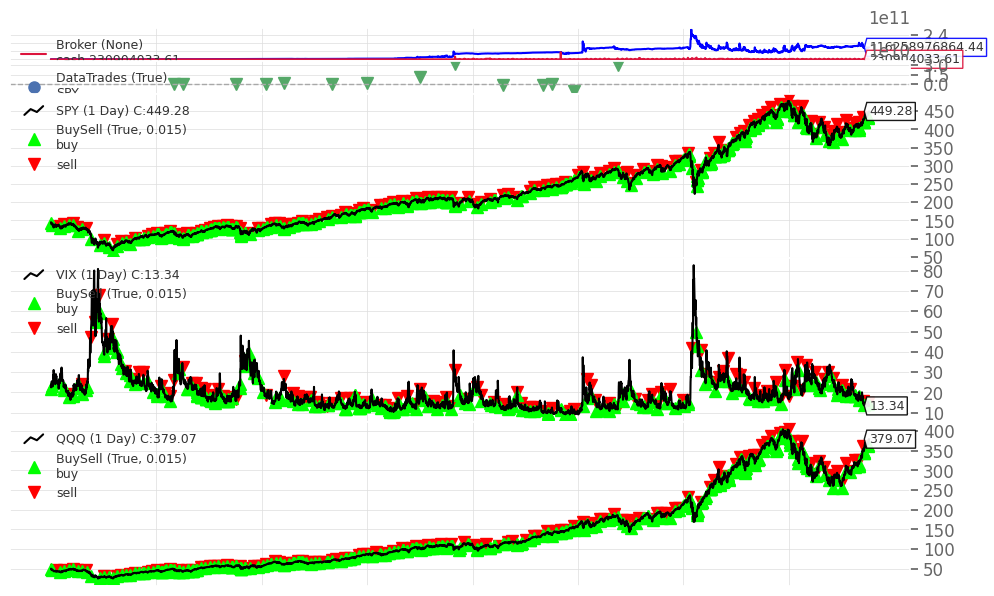

[[<Figure size 1000x600 with 5 Axes>]]

In [379]:
%matplotlib inline
plt.rcParams.update({'font.size': 12})
cb.plot(iplot=False, volume=False)


                           Strategy
-------------------------  ----------
Start Period               2008-01-02
End Period                 2023-07-14
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          11,525.90%
CAGR﹪                     23.53%

Sharpe                     0.74
Prob. Sharpe Ratio         99.94%
Smart Sharpe               0.71
Sortino                    1.42
Smart Sortino              1.37
Sortino/√2                 1.01
Smart Sortino/√2           0.97
Omega                      1.22

Max Drawdown               -78.11%
Longest DD Days            1230
Volatility (ann.)          83.94%
Calmar                     0.3
Skew                       4.91
Kurtosis                   72.6

Expected Daily %           0.12%
Expected Monthly %         2.58%
Expected Yearly %          34.61%
Kelly Criterion            9.21%
Risk of Ruin               0.0%
Daily Value-at-Risk        -8.45%
Expected Shortfall (cVaR)  -8.45%

Max Consecutive Wins 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-03-02,2021-10-21,2023-07-14,1230,-78.106620,-77.234770
2,2018-02-06,2018-02-26,2020-02-21,746,-56.944119,-48.718859
3,2008-10-28,2010-06-18,2011-06-14,960,-48.251607,-43.186700
4,2015-07-10,2015-07-17,2015-08-20,42,-40.131433,-39.330870
5,2014-12-17,2014-12-24,2015-03-09,83,-38.969866,-38.418457


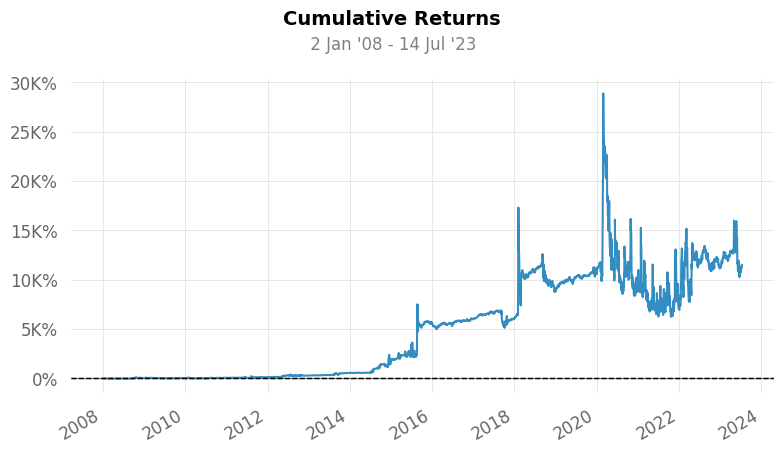

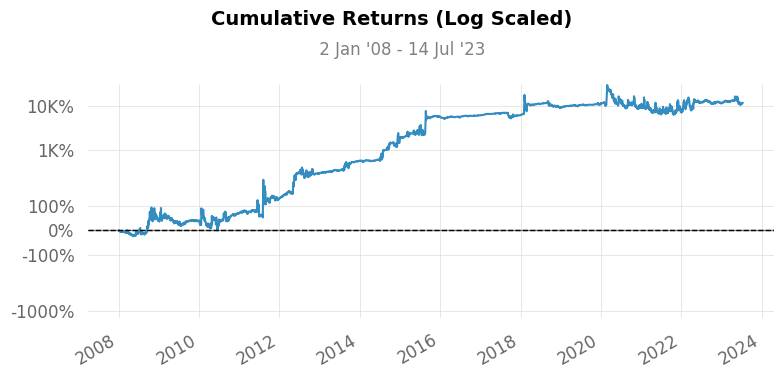

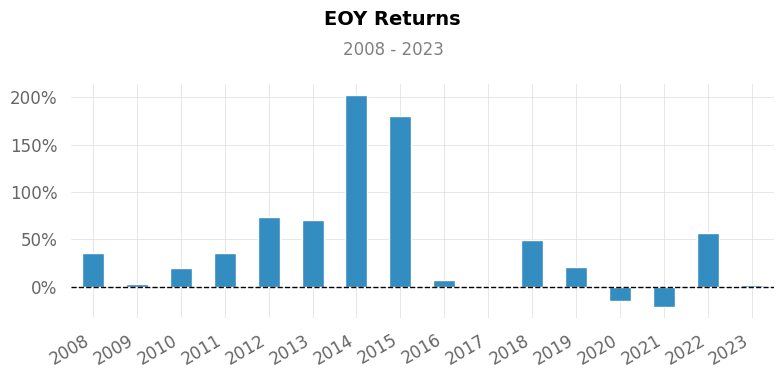

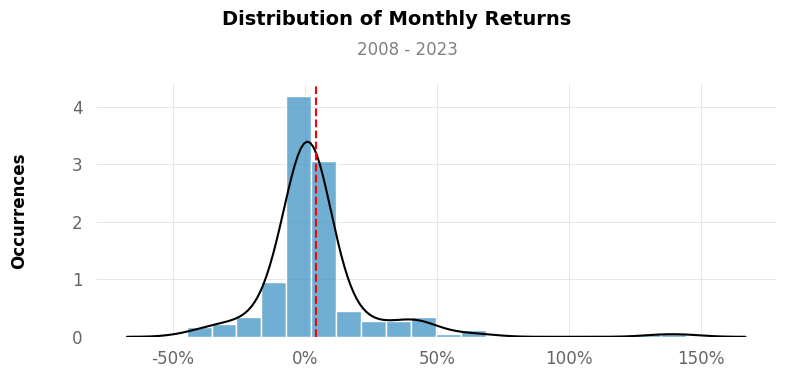

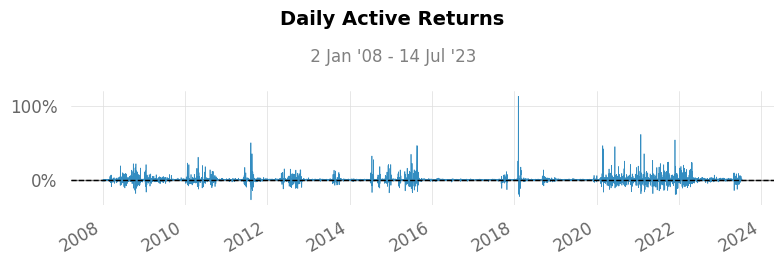

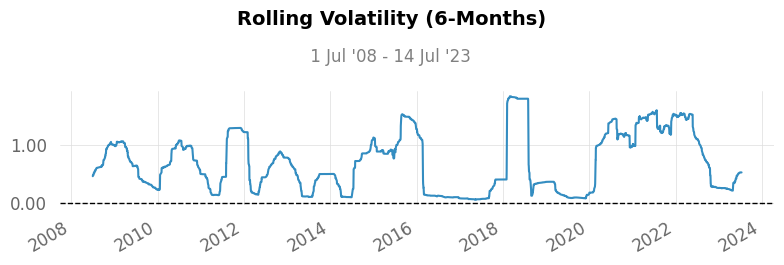

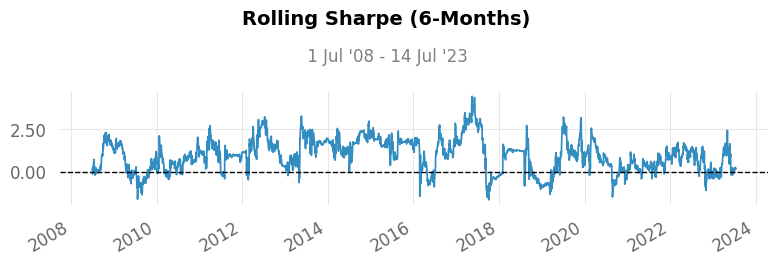

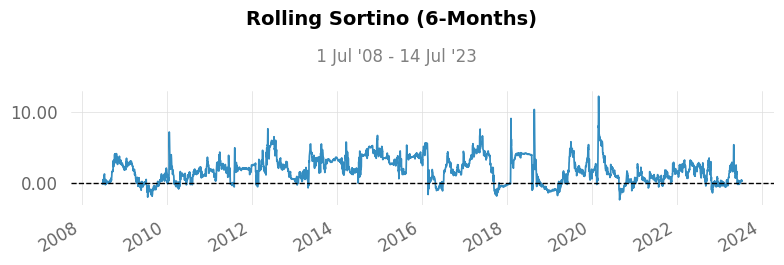

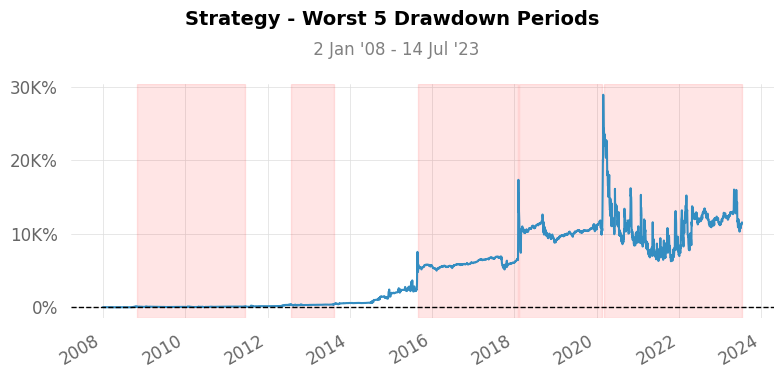

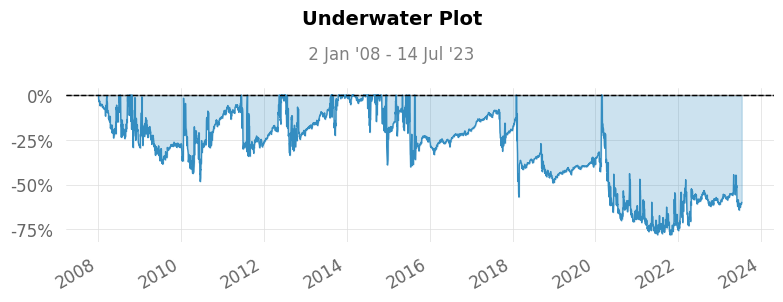

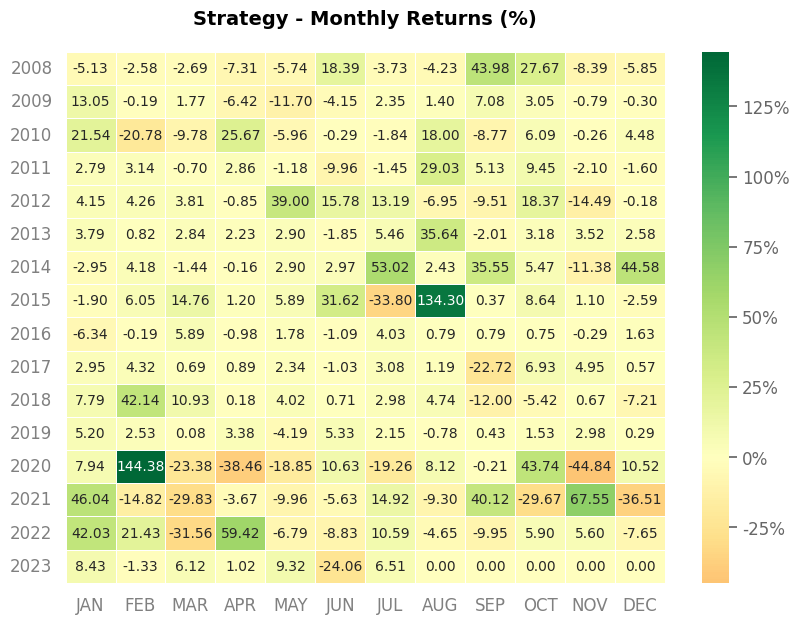

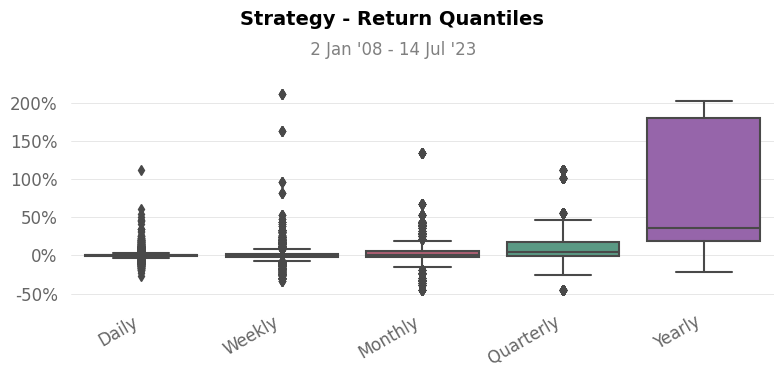

In [380]:

strats=results[0]
pyfoliozer = strats.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
qs.reports.full(returns)